<h3 style="text-align: center;"><b>Сегментация изображений</b></h3>
<h3 style="text-align: center;"><b>с применением сверточных нейронных сетей</b></h3>

# Загрузка данных

In [1]:
images = []
lesions = []
from skimage.io import imread
import os
root = './content/PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

In [2]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [3]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


нарисуем несколько изображений

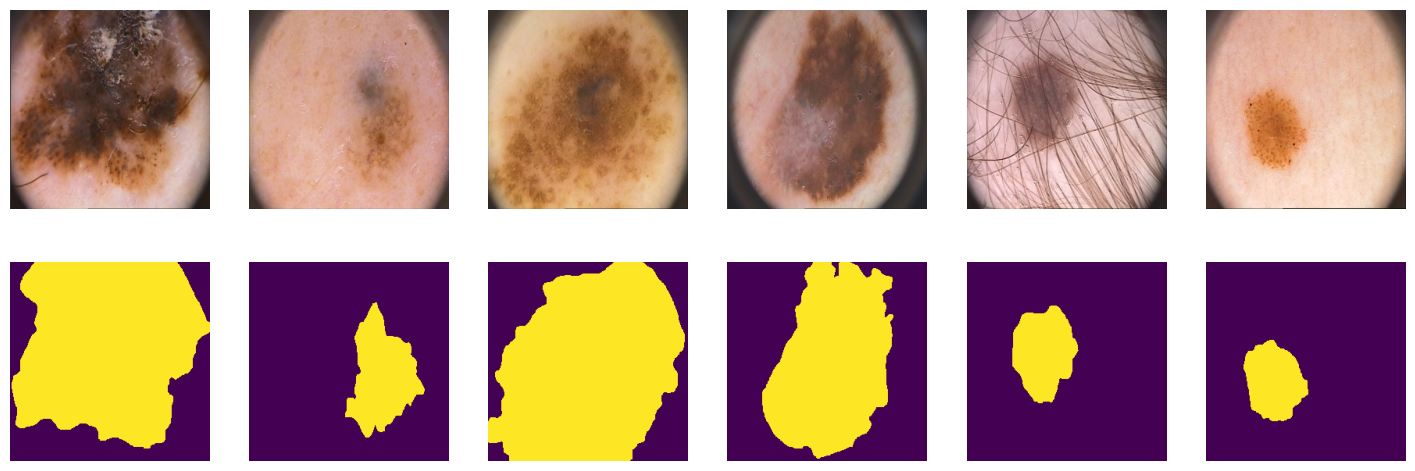

In [4]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [5]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [6]:
print(len(tr), len(val), len(ts))

100 50 50


## PyTorch DataLoader

In [7]:
print(X.shape)
print(Y.shape)

(200, 256, 256, 3)
(200, 256, 256)


In [8]:
from torch.utils.data import DataLoader
batch_size = 12
train_dataloader = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True, pin_memory=True)
valid_dataloader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True, pin_memory=True)

In [9]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Метрика

## IoU (intersection over union)

$I o U=\cfrac{\text{target } \cap \text{ prediction}}{\text{target } \cup \text{ prediction}}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


In [10]:
from torchmetrics import JaccardIndex

iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

## BCE Loss

*бинарная кросс-энтропия* (BCE loss):

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

численно стабильй BCE loss:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

### Вывод 

$$
    \mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] = \\[0.5em]
    = - \sum_i \left[ y_i \log \left( \cfrac{1}{1 + e^{-\hat{y}_i}} \right) + (1 - y_i) \log \left( 1 - \cfrac{1}{1 + e^{-\hat{y}_i}} \right) \right] = \\[0.5em]
    = - \sum_i \left[ y_i \log \left( \cfrac{1}{1 + e^{-\hat{y}_i}} \right) + (1 - y_i) \log \left( \cfrac{e^{-\hat{y}_i}}{1 + e^{-\hat{y}_i}} \right) \right] = \\[0.5em]
    = - \sum_i \left[ - y_i \log \left( 1 + e^{-\hat{y}_i} \right) + (1 - y_i) \left( (-\hat{y}_i) - \log \left( 1 + e^{-\hat{y}_i} \right) \right) \right] = \\[0.5em]
    = \sum_i \left[ y_i \log \left( 1 + e^{-\hat{y}_i} \right) + (1 - y_i) \left( \hat{y}_i + \log \left( 1 + e^{-\hat{y}_i} \right) \right) \right] = \\[0.5em] 
    = \sum_i \left[ y_i \log \left( 1 + e^{-\hat{y}_i} \right) + \hat{y}_i + \log \left( 1 + e^{-\hat{y}_i} \right) - y_i \hat{y}_i - y_i \log \left( 1 + e^{-\hat{y}_i} \right) \right] = \\[0.5em]
    = \sum_i \left[ \hat{y}_i - y_i \hat{y}_i + \log \left( 1 + e^{-\hat{y}_i} \right) \right]
$$

### Реализуем в коде оба варианта лосса 

In [11]:
import torch.nn.functional as F
import torch.nn as nn

In [12]:
bce_torch = nn.BCELoss(reduction='sum') # (sigmoid(y_pred), y_real)
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction='sum')

In [13]:
def bce_loss(y_pred, y_real):
  return torch.sum(y_pred - y_real * y_pred + torch.log1p(torch.exp(-y_pred)))

def bce_true(y_pred, y_real):
  return -torch.sum(y_real * torch.log(F.sigmoid(y_pred)) + (1 - y_real) * torch.log1p(-F.sigmoid(y_pred)))

Проверим корректность работы на простом примере

In [14]:
y_pred = torch.randn(3, 2, requires_grad=False)
y_true = torch.rand(3, 2, requires_grad=False)

labels = [
    "BCE loss (classic, by hand)",
    "BCE loss (logits,  by hand)",
    "BCE loss (classic, torch)",
    "BCE loss (logits,  torch)",
]

width = max(map(len, labels))

print(f'{labels[0]:<{width}} = {bce_true(y_pred, y_true)}')
print(f'{labels[1]:<{width}} = {bce_loss(y_pred, y_true)}')
print(f'{labels[2]:<{width}} = {bce_torch(torch.sigmoid(y_pred), y_true)}')
print(f'{labels[3]:<{width}} = {bce_torch_with_logits(y_pred, y_true)}')


BCE loss (classic, by hand) = 5.110727787017822
BCE loss (logits,  by hand) = 5.110727787017822
BCE loss (classic, torch)   = 5.110727787017822
BCE loss (logits,  torch)   = 5.110727787017822


In [15]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))

In [16]:
y_pred = torch.randn((2, 1, 3, 3), requires_grad=False)
y_true = torch.randint(0, 2, (2, 1, 3, 3))

print(f'{labels[0]:<{width}} = {bce_true(y_pred, y_true)}')
print(f'{labels[1]:<{width}} = {bce_loss(y_pred, y_true)}')
print(f'{labels[2]:<{width}} = {bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))}')
print(f'{labels[3]:<{width}} = {bce_torch_with_logits(y_pred, y_true.to(torch.float))}')

BCE loss (classic, by hand) = 15.792725563049316
BCE loss (logits,  by hand) = 15.792724609375
BCE loss (classic, torch)   = 15.792725563049316
BCE loss (logits,  torch)   = 15.792725563049316


In [17]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))

Посчитаем на реальных логитах и сегментационной маске:

In [18]:
path_to_dummy_samples = './content/for_asserts'
dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
                 'labels': torch.load(f'{path_to_dummy_samples}/labels.pt')}
dummpy_sample['labels'] = dummpy_sample['labels'].to(device)
dummpy_sample['logits'] = dummpy_sample['logits'].to(device)

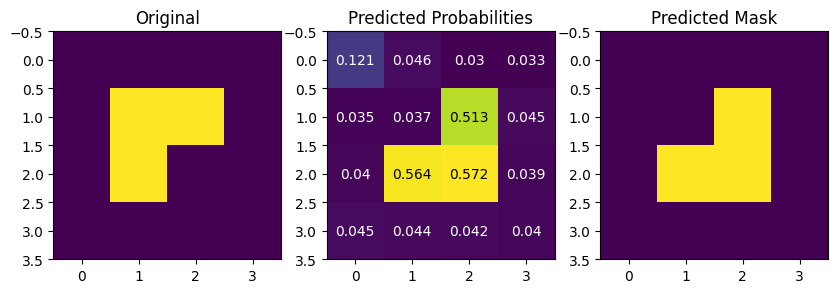

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10,3*10))

ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
    if label < 0.5:
        color = 'white'
    else:
        color = 'black'
    ax2.text(i,j,round(label,3), color=color, ha='center',va='center')

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

In [20]:
bce_loss_score = bce_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_true_score = bce_true(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_torch_score = bce_torch(torch.sigmoid(dummpy_sample['logits'].cpu()), dummpy_sample['labels'].cpu().float())
bce_torch_with_logits_score = bce_torch_with_logits(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu().float())
assert np.isclose(bce_loss_score, bce_torch_score)
assert np.isclose(bce_loss_score, bce_torch_with_logits_score)
assert np.isclose(bce_true_score, bce_torch_score)
assert np.isclose(bce_true_score, bce_torch_with_logits_score)

## SegNet

Реализуем SegNet архитектуру.

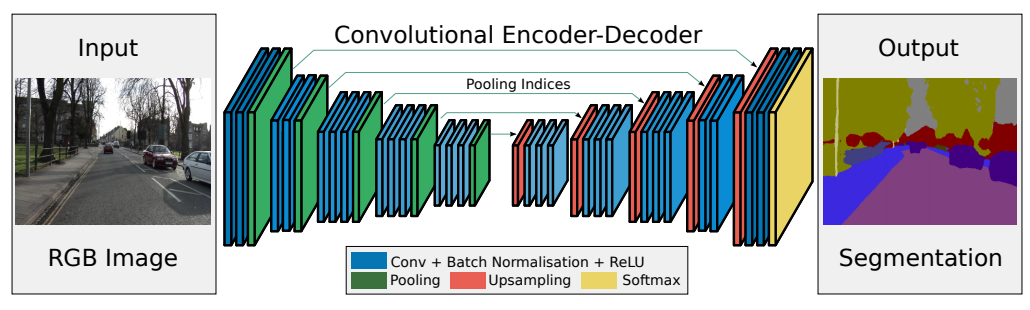

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [22]:
test = torch.randn(32, 3, 224, 224)
enc_conv = nn.Conv2d(3, 64, 1, padding=0)
enc_pool = nn.MaxPool2d(2, stride=2)

test = enc_conv(test)
# test = enc_pool(test)

test.size()

torch.Size([32, 64, 224, 224])

In [23]:
class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        # VGG-16 architecture
        self.enc_conv1_1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.enc_conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.enc_bn1_1 = nn.BatchNorm2d(64)
        self.enc_bn1_2 = nn.BatchNorm2d(64)
        self.enc_pool1 = nn.MaxPool2d(2, stride=2, return_indices=True)

        self.enc_conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.enc_conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.enc_bn2_1 = nn.BatchNorm2d(128)
        self.enc_bn2_2 = nn.BatchNorm2d(128)
        self.enc_pool2 = nn.MaxPool2d(2, stride=2, return_indices=True)

        self.enc_conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.enc_conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.enc_conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.enc_bn3_1 = nn.BatchNorm2d(256)
        self.enc_bn3_2 = nn.BatchNorm2d(256)
        self.enc_bn3_3 = nn.BatchNorm2d(256)
        self.enc_pool3 = nn.MaxPool2d(2, stride=2, return_indices=True)

        self.enc_conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.enc_conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.enc_conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.enc_bn4_1 = nn.BatchNorm2d(512)
        self.enc_bn4_2 = nn.BatchNorm2d(512)
        self.enc_bn4_3 = nn.BatchNorm2d(512)
        self.enc_pool4 = nn.MaxPool2d(2, stride=2, return_indices=True)   

        # bottleneck
        self.bnck_enc_conv1 = nn.Conv2d(512, 512, 3, padding=1)
        self.bnck_enc_conv2 = nn.Conv2d(512, 512, 3, padding=1)
        self.bnck_enc_conv3 = nn.Conv2d(512, 512, 3, padding=1)
        self.bnck_enc_bn1 = nn.BatchNorm2d(512)
        self.bnck_enc_bn2 = nn.BatchNorm2d(512)
        self.bnck_enc_bn3 = nn.BatchNorm2d(512)
        self.bnck_enc_pool = nn.MaxPool2d(2, stride=2, return_indices=True)  

        self.bnck_dec_conv1 = nn.Conv2d(512, 512, 3, padding=1)
        self.bnck_dec_conv2 = nn.Conv2d(512, 512, 3, padding=1)
        self.bnck_dec_conv3 = nn.Conv2d(512, 512, 3, padding=1)  
        self.bnck_dec_bn1 = nn.BatchNorm2d(512)
        self.bnck_dec_bn2 = nn.BatchNorm2d(512)
        self.bnck_dec_bn3 = nn.BatchNorm2d(512)
        self.bnck_dec_up = nn.MaxUnpool2d(2, stride=2)

        # decoder (upsampling)
        self.dec_conv1_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.dec_conv1_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.dec_conv1_3 = nn.Conv2d(512, 256, 3, padding=1)  
        self.dec_bn1_1 = nn.BatchNorm2d(512)
        self.dec_bn1_2 = nn.BatchNorm2d(512)
        self.dec_bn1_3 = nn.BatchNorm2d(256)
        self.dec_up1 = nn.MaxUnpool2d(2, stride=2)

        self.dec_conv2_1 = nn.Conv2d(256, 256, 3, padding=1)
        self.dec_conv2_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.dec_conv2_3 = nn.Conv2d(256, 128, 3, padding=1)  
        self.dec_bn2_1 = nn.BatchNorm2d(256)
        self.dec_bn2_2 = nn.BatchNorm2d(256)
        self.dec_bn2_3 = nn.BatchNorm2d(128)
        self.dec_up2 = nn.MaxUnpool2d(2, stride=2)

        self.dec_conv3_1 = nn.Conv2d(128, 128, 3, padding=1)
        self.dec_conv3_2 = nn.Conv2d(128, 64, 3, padding=1)
        self.dec_bn3_1 = nn.BatchNorm2d(128)
        self.dec_bn3_2 = nn.BatchNorm2d(64)
        self.dec_up3 = nn.MaxUnpool2d(2, stride=2)

        self.dec_conv4_1 = nn.Conv2d(64, 64, 3, padding=1)
        self.dec_conv4_2 = nn.Conv2d(64, out_channels, 3, padding=1)
        self.dec_bn4_1 = nn.BatchNorm2d(64)
        self.dec_up4 = nn.MaxUnpool2d(2, stride=2)

    def forward(self, x):
        # encoder
        e1 = F.relu(self.enc_bn1_1(self.enc_conv1_1(x)))   # (N, 64, 224, 224)
        e1 = F.relu(self.enc_bn1_2(self.enc_conv1_2(e1)))  # (N, 64, 224, 224)
        e1, ind1 = self.enc_pool1(e1)                      # (N, 64, 112, 112)

        e2 = F.relu(self.enc_bn2_1(self.enc_conv2_1(e1)))  # (N, 128, 112, 112)
        e2 = F.relu(self.enc_bn2_2(self.enc_conv2_2(e2)))  # (N, 128, 112, 112)
        e2, ind2 = self.enc_pool2(e2)                      # (N, 128, 56,  56)

        e3 = F.relu(self.enc_bn3_1(self.enc_conv3_1(e2)))  # (N, 256, 56, 56)
        e3 = F.relu(self.enc_bn3_2(self.enc_conv3_2(e3)))  # (N, 256, 56, 56)
        e3 = F.relu(self.enc_bn3_3(self.enc_conv3_3(e3)))  # (N, 256, 56, 56)
        e3, ind3 = self.enc_pool3(e3)                      # (N, 256, 28, 28)

        e4 = F.relu(self.enc_bn4_1(self.enc_conv4_1(e3)))  # (N, 512, 28, 28)
        e4 = F.relu(self.enc_bn4_2(self.enc_conv4_2(e4)))  # (N, 512, 28, 28)
        e4 = F.relu(self.enc_bn4_3(self.enc_conv4_3(e4)))  # (N, 512, 28, 28)
        e4, ind4 = self.enc_pool4(e4)                      # (N, 512, 14, 14)

        # bottleneck
        b1 = F.relu(self.bnck_enc_bn1(self.bnck_enc_conv1(e4)))  # (N, 512, 14, 14)
        b1 = F.relu(self.bnck_enc_bn2(self.bnck_enc_conv2(b1)))  # (N, 512, 14, 14)
        b1 = F.relu(self.bnck_enc_bn3(self.bnck_enc_conv3(b1)))  # (N, 512, 14, 14)
        b1, ind5 = self.bnck_enc_pool(b1)                        # (N, 512, 7,  7)

        b2 = self.bnck_dec_up(b1, ind5)                          # (N, 512, 14, 14)  
        b2 = F.relu(self.bnck_dec_bn1(self.bnck_dec_conv1(b2)))  # (N, 512, 14, 14)
        b2 = F.relu(self.bnck_dec_bn2(self.bnck_dec_conv2(b2)))  # (N, 512, 14, 14)
        b2 = F.relu(self.bnck_dec_bn3(self.bnck_dec_conv3(b2)))  # (N, 512, 14, 14)

        # decoder
        d1 = self.dec_up1(b2, ind4)                        # (N, 512, 28, 28)  
        d1 = F.relu(self.dec_bn1_1(self.dec_conv1_1(d1)))  # (N, 256, 28, 28)
        d1 = F.relu(self.dec_bn1_2(self.dec_conv1_2(d1)))  # (N, 256, 28, 28)
        d1 = F.relu(self.dec_bn1_3(self.dec_conv1_3(d1)))  # (N, 256, 28, 28)

        d2 = self.dec_up2(d1, ind3)                        # (N, 256, 56, 56)  
        d2 = F.relu(self.dec_bn2_1(self.dec_conv2_1(d2)))  # (N, 128, 56, 56)
        d2 = F.relu(self.dec_bn2_2(self.dec_conv2_2(d2)))  # (N, 128, 56, 56)
        d2 = F.relu(self.dec_bn2_3(self.dec_conv2_3(d2)))  # (N, 128, 56, 56)

        d3 = self.dec_up3(d2, ind2)                        # (N, 128, 112, 112)  
        d3 = F.relu(self.dec_bn3_1(self.dec_conv3_1(d3)))  # (N, 64,  112, 112)
        d3 = F.relu(self.dec_bn3_2(self.dec_conv3_2(d3)))  # (N, 64,  112, 112)

        d4 = self.dec_up4(d3, ind1)                        # (N, 64,  224, 224)  
        d4 = F.relu(self.dec_bn4_1(self.dec_conv4_1(d4)))  # (N, out, 224, 224)
        d4 = self.dec_conv4_2(d4)                          # (N, out, 224, 224)

        return d4 # no activation


In [24]:
segnet_model = SegNet().to(device)
print(segnet_model)

SegNet(
  (enc_conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_bn1_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc_bn1_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_bn2_1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc_bn2_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_conv

In [25]:
class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        # VGG-16 architecture
        self.enc_block1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True)
        )

        self.enc_block2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True)
        )

        self.enc_block3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True)
        )

        self.enc_block4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True)   
        )

        # bottleneck
        self.bnck_enc = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True) 
        )

        self.bnck_dec_up = nn.MaxUnpool2d(2, stride=2)
        self.bnck_dec = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.dec_block1_up = nn.MaxUnpool2d(2, stride=2)
        self.dec_block1 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.dec_block2_up = nn.MaxUnpool2d(2, stride=2)
        self.dec_block2 = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.dec_block3_up = nn.MaxUnpool2d(2, stride=2)
        self.dec_block3 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.dec_block4_up = nn.MaxUnpool2d(2, stride=2)
        self.dec_block4 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, out_channels, 3, padding=1)
        )

    def forward(self, x):
        # encoder
        e1, ind1 = self.enc_block1(x)   # (N, 64,  112, 112)                   
        e2, ind2 = self.enc_block2(e1)  # (N, 128, 56,  56)
        e3, ind3 = self.enc_block3(e2)  # (N, 256, 28,  28)
        e4, ind4 = self.enc_block4(e3)  # (N, 512, 14,  14)

        # bottleneck
        b1, indb = self.bnck_enc(e4)  # (N, 512, 7,  7)

        b2_up = self.bnck_dec_up(b1, indb)  # (N, 512, 14, 14) 
        b2 = self.bnck_dec(b2_up)           # (N, 512, 14, 14)  

        # decoder
        d1_up = self.dec_block1_up(b2, ind4)  # (N, 512, 28, 28) 
        d1 = self.dec_block1(d1_up)           # (N, 256, 28, 28)

        d2_up = self.dec_block2_up(d1, ind3)  # (N, 256, 56, 56)
        d2 = self.dec_block2(d2_up)           # (N, 128, 56, 56)

        d3_up = self.dec_block3_up(d2, ind2)  # (N, 128, 112, 112)
        d3 = self.dec_block3(d3_up)           # (N, 64,  112, 112)

        d4_up = self.dec_block4_up(d3, ind1)  # (N, 64, 224, 224)
        d4 = self.dec_block4(d4_up)           # (N, out, 224, 224)            

        return d4  # no activation


## Тренировка

In [26]:
from tqdm.notebook import tqdm

from torchmetrics import JaccardIndex
from torchmetrics.classification import BinaryJaccardIndex

from torch.utils.tensorboard import SummaryWriter

import numpy as np

from datetime import datetime
from typing import Literal, Any
from queue import Queue
from pathlib import Path
import pathlib
import logging
import random
import os

In [27]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

In [29]:
class EarlyStopping():
    """
    Simple early-stopping monitor.

    Parameters
    ----------
    patience : int
        # successive unimproved epochs allowed.
    mode : {'min', 'max'}, default 'min'
        Track a metric to *minimise* (e.g. loss) or *maximise*
        (e.g. accuracy).
    min_delta : float, default 1e-3
        Minimum change regarded as an improvement.

    Methods
    -------
    __call__(val) -> bool
        Update with latest validation score *val*.  
        Returns **True** when patience is exhausted.
    reset()
        Clear internal state.
    best : float (property)
        Best score seen so far.
    """

    def __init__(
            self, patience : int, 
                  mode     : Literal['min', 'max'] = 'min',
                  min_delta: float = 1e-03):
        assert patience >= 0, f'[EarlyStopping] patience can\'t be negative.'
        self.patience  = patience
        self.min_delta = min_delta
        self.mode      = mode

        self._best_val = float('inf')
        self._counter  = 0

    def __call__(self, val: float) -> bool:
        assert val is not None, f'[EarlyStopping] val is None.'

        if self.mode == 'max' and self._best_val == float('inf'):
            self._best_val *= -1

        val = float(val)
        improved = (
            (self.mode == 'min' and self._best_val - val > self.min_delta) or
            (self.mode == 'max' and val - self._best_val > self.min_delta)
        )

        if improved:
            logging.debug(
                f'[EarlyStopping] Value improved ' 
                f'({self._best_val:.6f} -> {val:.6f}).'
            )
            self._counter  = 0
            self._best_val = val
            return False

        self._counter += 1

        if self._counter >= self.patience:
            logging.info(f'[EarlyStopping] Reached plateau, stopping...')
            return True
        
        return False

    def reset(self) -> None:
        self._best_val = float('inf') if self.mode == 'min' else -float('inf')
        self._counter = 0

    @property
    def best(self) -> float:
        return self._best_val


In [ ]:
class ModelUnwrapMixin:
    """Utility mix-in that peels off common wrappers (DDP, LoRA, etc.)."""

    @staticmethod
    def _unwrap(model: torch.nn.Module) -> torch.nn.Module:
        if hasattr(model, "_orig_mod"):  # e.g. LoRA, bits-and-bytes
            return model._orig_mod
        if hasattr(model, "module"):     # e.g. DistributedDataParallel
            return model.module
        return model


In [32]:
class CheckpointSaver(ModelUnwrapMixin):
    """
    Minimal checkpoint saver.

    Parameters
    ----------
    save_dir : str | Path, default 'checkpoint'
        Root folder; dated sub-folders are created automatically.
    prefix : str or None, optional
        Filename prefix (slashes → “|”).  Defaults to the model’s class name.
    limit : int or None, optional
        Keep at most *limit* recent checkpoints; ``None`` keeps all.
    **kw
        Passed through to ``ModelUnwrapMixin``.

    Methods
    -------
    save(model, epoch, *, train_loss=None, val_loss=None,
         train_metric=None, val_metric=None, optimizer=None) -> Path
        Dump model ``state_dict`` + stats to  
        ``<save_dir>/<DD-MM-YYYY>/<prefix>_epoch####_<HH-MM-SS>.pth``  
        and return the path.  Deletes the oldest file when *limit* is exceeded.
    """

    def __init__(
            self, *, save_dir: str | Path = 'checkpoint', 
                     prefix  : str | None = None, 
                     limit   : int | None = None, **kw):
        self.save_dir = Path(save_dir)

        self.prefix = (
            prefix.replace(os.sep, '|').replace('/', '|') 
            if prefix is not None else None
        )
        
        if limit is not None:
            assert limit > 0, f'[CheckpointSaver] limit must be a positive integer.'
            self.limit = limit 
            self._queue = Queue()
        else:
            self.limit = None

        super().__init__(**kw)

    def save(self, *, model        : torch.nn.Module, 
                      epoch        : int, 
                      train_loss   : float | None = None, 
                      val_loss     : float | None = None, 
                      train_metric : float | None = None, 
                      val_metric   : float | None = None, 
                      optimizer    : torch.optim.Optimizer | None = None) -> Path:
        model  = self._unwrap(model)
        prefix = self.prefix or model.__class__.__name__

        state = {
            'model'       : model.state_dict(),
            'epoch'       : epoch,
            'train_loss'  : train_loss,
            'val_loss'    : val_loss,
            'train_metric': train_metric,
            'val_metric'  : val_metric,          
            'optimizer'   : optimizer.state_dict() if optimizer else None,
        }

        now = datetime.now()

        today_dir = self.save_dir / now.strftime('%d-%m-%Y')
        today_dir.mkdir(parents=True, exist_ok=True)

        save_path = today_dir / f'{prefix}_epoch{epoch:04d}_{now:%H-%M-%S}.pth'
        torch.save(state, save_path)

        if self.limit:
            self._queue.put(save_path)
            if self._queue.qsize() > self.limit:
                self._queue.get().unlink(missing_ok=True)

        logging.info(f'[CheckpointSaver] Saved model to {save_path}.')

        return save_path


In [33]:
class CheckpointLoader(ModelUnwrapMixin):
    """
    Minimal checkpoint loader.

    Parameters
    ----------
    device : str, default 'cpu'
        Device to map tensors to when calling ``torch.load``.
    **kw
        Passed through to ``ModelUnwrapMixin``.

    Methods
    -------
    load(model, load_path)
        Unwrap *model*, load weights from *load_path*, and return the
        full checkpoint dictionary (epoch, losses, optimizer state,
        etc.).  Raises ``RuntimeError`` if *load_path* does not exist.
    """
    
    def __init__(
            self, *, device: str = 'cpu', **kw):
        self.device = device
        super().__init__(**kw)

    def load(self, *, model    : torch.nn.Module, 
                      load_path: str | Path) -> dict[str, Any]:
        unwrapped_model = self._unwrap(model)
        load_path = Path(load_path)

        if not load_path.exists():
            raise RuntimeError(f'[CheckpointLoader] Path doesn\'t exist: {load_path}.')

        chk = torch.load(load_path, map_location=self.device)
        unwrapped_model.load_state_dict(chk['model'])
        return chk  # caller can restore optimizer etc. if desired


In [34]:
class CheckpointManager(CheckpointSaver, CheckpointLoader):
    def __init__(
            self, *, save_dir: str | Path = 'checkpoint', 
                     prefix  : str | None = None,
                     limit   : int | None = None,
                     device  : str        = 'cpu'):
        super().__init__(save_dir=save_dir, prefix=prefix, limit=limit, device=device)


In [ ]:
# cm = CheckpointManager(save_dir='ckpt', prefix='run1', limit=3, device='cuda')
# print(cm.save_dir, cm.prefix, cm.limit, cm.device)

In [36]:
def train_epoch(
        model, loader, criterion, 
        optimizer, threshold, use_amp, scaler, 
        device): 
    model.train()
    
    running_loss = 0.
    total_size   = 0

    iou_metric = BinaryJaccardIndex(threshold=threshold).to(device)
    for x_batch, y_batch in tqdm(loader, desc='batch', leave=False):
        x_batch = x_batch.to(device, non_blocking=True)
        y_batch = y_batch.to(device, non_blocking=True)

        batch_size = x_batch.size(0)
        optimizer.zero_grad()

        with torch.amp.autocast(device_type=device.type, enabled=use_amp):
            logits = model(x_batch)
            batch_loss = criterion(logits, y_batch)

        if use_amp:
            scaler.scale(batch_loss).backward()
            scaler.unscale_(optimizer) 
        else:
            batch_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        if use_amp:
            scaler.step(optimizer)
            scaler.update()
        else:
            optimizer.step()

        with torch.no_grad():
            iou_metric.update(logits.detach(), y_batch)

            running_loss += batch_loss.item() * batch_size
            total_size   += batch_size

    loss = running_loss / total_size
    iou_score = iou_metric.compute()
    # iou_metric.reset()

    return loss, iou_score


@torch.no_grad()
def val_epoch(
        model, loader, criterion, 
        threshold, use_amp, device):
    model.eval()

    running_loss = 0.
    total_size   = 0

    iou_metric = BinaryJaccardIndex(threshold=threshold).to(device)
    for x_batch, y_batch in tqdm(loader, desc='batch', leave=False):
        x_batch = x_batch.to(device, non_blocking=True)
        y_batch = y_batch.to(device, non_blocking=True)

        batch_size = x_batch.size(0)

        with torch.amp.autocast(device_type=device.type, enabled=use_amp):
            logits = model(x_batch)
            batch_loss = criterion(logits, y_batch)

        iou_metric.update(logits.detach(), y_batch)

        running_loss += batch_loss.item() * batch_size
        total_size   += batch_size

    loss = running_loss / total_size
    iou_score = iou_metric.compute()
    # iou_metric.reset()

    return loss, iou_score


def train(
        model, trainloader, valloader, criterion, optimizer, 
        scheduler, epochs, experiment, threshold=0.5, use_amp=False, scaler=None, 
        writer_dir=None, early_stopping=None, checkpointing=None, device='cpu', compile_flag=True):
    if use_amp and scaler is None:
        raise ValueError('amp must be used with a scaler')

    device = torch.device(device)
    if device.type=='cuda' and not torch.cuda.is_available():
        raise ValueError('cuda is not available')

    if use_amp and device.type=='cpu':
        raise RuntimeError('AMP cannot run on CPU')

    model.to(device)
    if compile_flag and device.type=='cuda':
        model = torch.compile(model)

    # if writer_dir and not os.path.isdir(writer_dir):
    # 	os.mkdir(writer_dir)

    if writer_dir:
        os.makedirs(writer_dir, exist_ok=True)

    writer = SummaryWriter(
        log_dir=str(
            pathlib.Path(writer_dir) 
            / datetime.now().strftime("%d-%m-%Y")
            / f'experiment_{experiment}_{datetime.now().strftime("%H:%M:%S")}'
        )
    ) if writer_dir else None

    best_model_path = None
    best_loss_val = float('inf')
    for epoch in tqdm(range(epochs), desc='epoch'):
        # train one epoch
        loss_train_epoch, iou_train_epoch = train_epoch(
            model, trainloader, criterion, optimizer, 
            threshold, use_amp, scaler, device
        )

        # validate one epoch
        loss_val_epoch, iou_val_epoch = val_epoch(
            model, valloader, criterion,  
            threshold, use_amp, device
        )

        logging.info(f'[train]: epoch{epoch}, train loss: {loss_train_epoch}')
        logging.info(f'[train]: epoch{epoch}, val loss: {loss_val_epoch}')

        if writer:
            writer.add_scalar('loss/train', loss_train_epoch, epoch)
            writer.add_scalar('IoU/train',  iou_train_epoch,  epoch)
            writer.add_scalar('loss/val', loss_val_epoch, epoch)
            writer.add_scalar('IoU/val',  iou_val_epoch,  epoch)

            writer.add_scalar('LR', optimizer.param_groups[0]["lr"], epoch)

        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(loss_val_epoch)
        else:
            scheduler.step()

        if best_loss_val - loss_val_epoch > 1e-3:
            logging.debug(f'[train]: checkpoint save invoked')
            best_model_path = checkpointing.save(
                model=model, epoch=epoch, train_loss=loss_train_epoch, 
                val_loss=loss_val_epoch, train_metric=iou_train_epoch,
                val_metric=iou_val_epoch, optimizer=optimizer
            )
            best_loss_val = loss_val_epoch

        if early_stopping and early_stopping(loss_val_epoch):
            logging.info(f'[train]: early stopping triggered')
            break
    if best_model_path is not None:
        logging.info(f'[train]: training done, loading best model at: {best_model_path}')
        checkpointing.load(model=model, load_path=best_model_path)

    if writer:
        writer.close()

Обучим модель **SegNet**

In [37]:
logging.basicConfig(
    # level=logging.DEBUG,
    level=logging.INFO,
    # level=logging.WARNING,
    format="{asctime} - {levelname} - {message}",
    style="{",
    datefmt="%d-%m-%Y %H:%M:%S",
)

In [38]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

segnet_model1 = SegNet().to(device)
# print(segnet_model1)

# for module in segnet_model1.modules():
#     if isinstance(module, nn.BatchNorm2d):
#         module.eps = 1e-4

start_event = torch.cuda.Event(enable_timing=True)
end_event   = torch.cuda.Event(enable_timing=True)

optimizer = torch.optim.AdamW(segnet_model1.parameters(), lr=1e-3, weight_decay=1e-4)  # 1e-3 # 1.75e-3
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)
scaler    = torch.amp.GradScaler(device=device.type) 
early_stopping = EarlyStopping(patience=10, mode='min')
checkpointing  = CheckpointManager(limit=3, device=device.type)

experiment = 'criterion=BCEWithLogitsLoss;batch_size=12;BatchNorm2d.eps=default;patience=5\\10;epochs=30;lr=1e-3'

config = {
    'model'         : segnet_model1,
    'trainloader'   : train_dataloader,
    'valloader'     : valid_dataloader,
    'criterion'     : nn.BCEWithLogitsLoss(),
    'optimizer'     : optimizer,
    'scheduler'     : scheduler,
    'scaler'        : scaler,
    'early_stopping': early_stopping,
    'checkpointing' : checkpointing,
    'epochs'        : 30,
    'experiment'    : experiment,
    'use_amp'       : False,  # try turning off
    'writer_dir'    : 'summary',
    'device'        : device,
    'compile_flag'  : True
}

start_event.record()
train(**config) 
end_event.record()

torch.cuda.synchronize()
elapsed_ms = start_event.elapsed_time(end_event)

seconds = elapsed_ms/1000
minutes, leftover_seconds = seconds//60, seconds%60
print(f"Training took {minutes}m {leftover_seconds:.3f}s")

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

batch:   0%|          | 0/9 [00:00<?, ?it/s]

W0805 13:26:33.751000 16052 torch/_inductor/utils.py:1250] [0/0] Not enough SMs to use max_autotune_gemm mode


batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:27:28 - INFO - [train]: epoch0, train loss: 0.573858289718628
05-08-2025 13:27:28 - INFO - [train]: epoch0, val loss: 0.6318026971817017
05-08-2025 13:27:29 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/SegNet_epoch0000_13-27-28.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:27:34 - INFO - [train]: epoch1, train loss: 0.39086246252059936
05-08-2025 13:27:34 - INFO - [train]: epoch1, val loss: 1.5051924192905426


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:27:39 - INFO - [train]: epoch2, train loss: 0.3020713222026825
05-08-2025 13:27:39 - INFO - [train]: epoch2, val loss: 0.5123486256599427
05-08-2025 13:27:39 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/SegNet_epoch0002_13-27-39.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:27:45 - INFO - [train]: epoch3, train loss: 0.2769640094041824
05-08-2025 13:27:45 - INFO - [train]: epoch3, val loss: 0.5039219617843628
05-08-2025 13:27:45 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/SegNet_epoch0003_13-27-45.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:27:50 - INFO - [train]: epoch4, train loss: 0.30571880102157595
05-08-2025 13:27:50 - INFO - [train]: epoch4, val loss: 0.3076356911659241
05-08-2025 13:27:50 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/SegNet_epoch0004_13-27-50.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:27:55 - INFO - [train]: epoch5, train loss: 0.2672538506984711
05-08-2025 13:27:55 - INFO - [train]: epoch5, val loss: 0.31435782194137574


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:28:01 - INFO - [train]: epoch6, train loss: 0.2755034053325653
05-08-2025 13:28:01 - INFO - [train]: epoch6, val loss: 0.37842531442642213


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:28:06 - INFO - [train]: epoch7, train loss: 0.28455174148082735
05-08-2025 13:28:06 - INFO - [train]: epoch7, val loss: 0.35116358041763307


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:28:11 - INFO - [train]: epoch8, train loss: 0.28593097925186156
05-08-2025 13:28:11 - INFO - [train]: epoch8, val loss: 0.3766867804527283


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:28:16 - INFO - [train]: epoch9, train loss: 0.26362388491630556
05-08-2025 13:28:16 - INFO - [train]: epoch9, val loss: 0.3975138282775879


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:28:21 - INFO - [train]: epoch10, train loss: 0.28282405495643614
05-08-2025 13:28:21 - INFO - [train]: epoch10, val loss: 0.8007024252414703


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:28:27 - INFO - [train]: epoch11, train loss: 0.2780254691839218
05-08-2025 13:28:27 - INFO - [train]: epoch11, val loss: 0.3312715268135071


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:28:32 - INFO - [train]: epoch12, train loss: 0.27049523055553437
05-08-2025 13:28:32 - INFO - [train]: epoch12, val loss: 0.2837295877933502
05-08-2025 13:28:32 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/SegNet_epoch0012_13-28-32.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:28:37 - INFO - [train]: epoch13, train loss: 0.2625515604019165
05-08-2025 13:28:37 - INFO - [train]: epoch13, val loss: 0.2645150756835937
05-08-2025 13:28:38 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/SegNet_epoch0013_13-28-37.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:28:43 - INFO - [train]: epoch14, train loss: 0.26437746822834013
05-08-2025 13:28:43 - INFO - [train]: epoch14, val loss: 0.2633176726102829
05-08-2025 13:28:43 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/SegNet_epoch0014_13-28-43.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:28:48 - INFO - [train]: epoch15, train loss: 0.23338022470474243
05-08-2025 13:28:48 - INFO - [train]: epoch15, val loss: 0.25477046608924864
05-08-2025 13:28:49 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/SegNet_epoch0015_13-28-48.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:28:54 - INFO - [train]: epoch16, train loss: 0.24711913108825684
05-08-2025 13:28:54 - INFO - [train]: epoch16, val loss: 0.25121058225631715
05-08-2025 13:28:54 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/SegNet_epoch0016_13-28-54.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:28:59 - INFO - [train]: epoch17, train loss: 0.2459938955307007
05-08-2025 13:28:59 - INFO - [train]: epoch17, val loss: 0.24950343608856201
05-08-2025 13:29:00 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/SegNet_epoch0017_13-28-59.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:29:05 - INFO - [train]: epoch18, train loss: 0.22951762557029723
05-08-2025 13:29:05 - INFO - [train]: epoch18, val loss: 0.24779099643230437
05-08-2025 13:29:05 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/SegNet_epoch0018_13-29-05.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:29:10 - INFO - [train]: epoch19, train loss: 0.23047244131565095
05-08-2025 13:29:10 - INFO - [train]: epoch19, val loss: 0.2471764051914215


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:29:16 - INFO - [train]: epoch20, train loss: 0.24401716649532318
05-08-2025 13:29:16 - INFO - [train]: epoch20, val loss: 0.26540071666240694


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:29:21 - INFO - [train]: epoch21, train loss: 0.22504952192306518
05-08-2025 13:29:21 - INFO - [train]: epoch21, val loss: 0.24450799226760864
05-08-2025 13:29:21 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/SegNet_epoch0021_13-29-21.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:29:27 - INFO - [train]: epoch22, train loss: 0.2123701387643814
05-08-2025 13:29:27 - INFO - [train]: epoch22, val loss: 0.24051243901252747
05-08-2025 13:29:27 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/SegNet_epoch0022_13-29-27.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:29:32 - INFO - [train]: epoch23, train loss: 0.22360532402992248
05-08-2025 13:29:32 - INFO - [train]: epoch23, val loss: 0.24243107676506043


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:29:37 - INFO - [train]: epoch24, train loss: 0.23566935777664186
05-08-2025 13:29:37 - INFO - [train]: epoch24, val loss: 0.2417510664463043


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:29:42 - INFO - [train]: epoch25, train loss: 0.21214109420776367
05-08-2025 13:29:42 - INFO - [train]: epoch25, val loss: 0.24950354814529419


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:29:48 - INFO - [train]: epoch26, train loss: 0.21880828380584716
05-08-2025 13:29:48 - INFO - [train]: epoch26, val loss: 0.23338906168937684
05-08-2025 13:29:48 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/SegNet_epoch0026_13-29-48.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:29:53 - INFO - [train]: epoch27, train loss: 0.23159024655818938
05-08-2025 13:29:53 - INFO - [train]: epoch27, val loss: 0.23595145285129548


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:29:58 - INFO - [train]: epoch28, train loss: 0.2033988916873932
05-08-2025 13:29:58 - INFO - [train]: epoch28, val loss: 0.24103619337081908


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:30:04 - INFO - [train]: epoch29, train loss: 0.19646981000900268
05-08-2025 13:30:04 - INFO - [train]: epoch29, val loss: 0.23806196689605713
05-08-2025 13:30:04 - INFO - [train]: training done, loading best model at: checkpoint/05-08-2025/SegNet_epoch0026_13-29-48.pth


Training took 3.0m 37.248s


In [39]:
# %load_ext tensorboard
# %tensorboard --logdir '/home/nikita91/Documents/VScodeProjects/DLS/SEMESTER 1/16HW/summary' --port 6006

# # (go to http://localhost:6006)

## Инференс

In [40]:
# @torch.inference_mode()
def test(
        model, testloader, criterion, experiment, threshold=0.5, 
        writer_dir=None, compile_flag=True, device='cpu', use_amp=False):
    device = torch.device(device)
    if device.type=='cuda' and not torch.cuda.is_available():
        raise ValueError('cuda is not available')

    if use_amp and device.type=='cpu':
        raise RuntimeError('AMP cannot run on CPU')

    model.to(device)

    if compile_flag and device.type=='cuda':
        model = torch.compile(model)

    if writer_dir:
        os.makedirs(writer_dir, exist_ok=True)

    writer = SummaryWriter(
        log_dir=str(
            pathlib.Path(writer_dir) 
            / datetime.now().strftime("%d-%m-%Y")
            / f'experiment_{experiment}_{datetime.now().strftime("%H:%M:%S")}'
        )
    ) if writer_dir else None
    
    loss_test, iou_test = val_epoch(
        model, testloader, criterion,  
        threshold, use_amp, device
    )
    
    logging.info(f"[test]: loss={loss_test}, IoU={iou_test}")

    if writer:
        writer.add_scalar("loss/test", loss_test, 0)
        writer.add_scalar("IoU/test",  iou_test,  0)
        writer.close()


In [41]:
test(segnet_model1, test_dataloader, nn.BCEWithLogitsLoss(), 'test_'+experiment, 
     writer_dir='summary', compile_flag=True, device='cuda', use_amp=False)


batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:30:05 - INFO - [test]: loss=0.18768527388572692, IoU=0.7975640296936035


## Визуализация результатов

In [42]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

In [43]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = np.array(inp)
    inp = inp.transpose((1, 2, 0))
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

idx: [13 39 30 45 17 48]


/tmp/ipykernel_16052/1226885637.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  inp = np.array(inp)


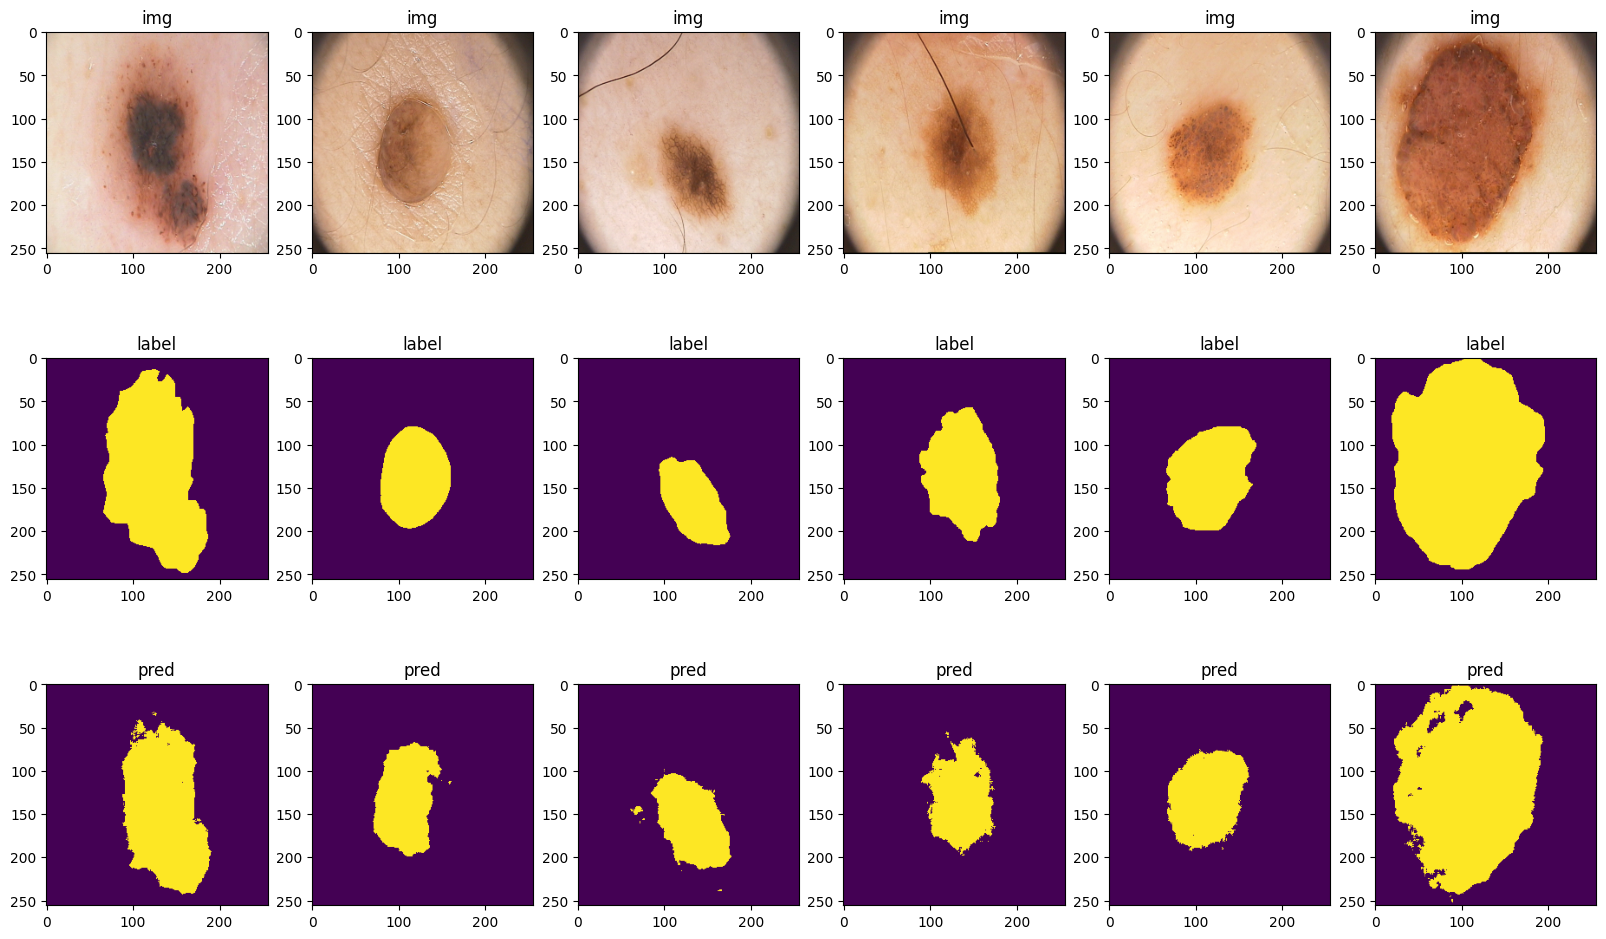

In [44]:
def draw(
        model, dataset, size=6, threshold=0.5, 
        verbose=False, figsize=(20, 12)):
    model.eval()

    fig, ax = plt.subplots(nrows=3, ncols=size, figsize=figsize)
    idx = np.random.choice(len(dataset), size=size, replace=False)
    if verbose:
        print(f'idx: {idx}')
    
    for i, (x, y, y_hat) in zip(idx, ax.T):
        im_val, label = dataset[i]
        imshow(im_val.data, plt_ax=x, title='img')
        imshow(label.data,  plt_ax=y, title='label')
        
        with torch.no_grad():
            im_val = torch.from_numpy(im_val).float()
            im_val = im_val.unsqueeze(0).to(device)
            logits = model(im_val)
            prob   = F.sigmoid(logits)
            pred   = (prob > threshold).to(int)

        imshow(pred.cpu().squeeze(0), plt_ax=y_hat, title='pred')

draw(segnet_model1, test_dataloader.dataset, verbose=True)

## Дополнительные функции потерь

### Dice Loss

In [45]:
def dice_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5, eps: float = 1e-8):
    prob = F.sigmoid(logits)
    pred = (prob > threshold)

    pred, labels = pred.to(int), labels.to(int)

    tp = pred & labels
    fp = pred - tp
    fn = labels - tp
    
    tp, fp, fn = torch.sum(tp), torch.sum(fp), torch.sum(fn)

    score = (2 * tp + eps) / (2 * tp + fp + fn + eps)

    return score

Проверим на корректность функцию dice_score:

In [46]:
from torchmetrics.segmentation import DiceScore

dice = DiceScore(num_classes=1, average='micro').to(device)
torch_dice = dice(
    (dummpy_sample['logits'].sigmoid() > 0.5).to(int), 
    dummpy_sample['labels'].to(int)
)

my_dice = dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

print(f'torch: {torch_dice}')
print(f'mine:  {my_dice}')

torch: 0.6666666865348816
mine:  0.6666666865348816


/home/nikita91/.pyenv/versions/3.13.2/envs/science-venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: DiceScore metric currently defaults to `average=micro`, but will change to`average=macro` in the v1.9 release. If you've explicitly set this parameter, you can ignore this warning.
  warnings.warn(*args, **kwargs)


In [48]:
assert dice((dummpy_sample['logits'].sigmoid() > 0.5).to(int), dummpy_sample['labels'].to(int)) == dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

In [49]:
def dice_loss(logits: torch.Tensor, labels: torch.Tensor, eps: float = 1e-8):
    prob = F.sigmoid(logits)

    prob, labels = prob.float(), labels.float()

    tp = prob * labels
    fp = prob - tp
    fn = labels - tp
    
    tp, fp, fn = torch.sum(tp), torch.sum(fp), torch.sum(fn)

    prob_score = (2 * tp + eps) / (2 * tp + fp + fn + eps)

    return 1 - prob_score

Проверка на корректность:

In [50]:
from segmentation_models_pytorch.losses import DiceLoss

dice_loss_torch = DiceLoss(mode='binary')
torch_dice_loss = dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'])

mine_dice_loss = dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

print(f'torch: {torch_dice_loss}')
print(f'mine:  {mine_dice_loss}')

torch: 0.5755997896194458
mine:  0.5755997896194458


In [51]:
assert dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'].to(int)) == dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

### Focal Loss

Из оригинальной статьи по [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf):

$$p_t = \sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)$$

$$\mathcal L_{focal}(y, \hat y) = (1 - p_t)^{\gamma} \mathcal L_{BCE}(y_i, \hat y_i).$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - p_t)^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - (\sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)))^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [52]:
from torchvision.ops import sigmoid_focal_loss

In [53]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    prob = F.sigmoid(y_pred)
    p_t = prob * y_real + (1 - prob) * (1 - y_real)

    # return torch.sum((1 - p_t)**gamma * F.binary_cross_entropy(prob, y_real, reduction='none'))
    
    return torch.sum((1 - p_t)**gamma * F.binary_cross_entropy_with_logits(y_pred, y_real, reduction='none'))

    # return - torch.sum(
    #     (1 - (prob * y_real + (1 - prob) * (1 - y_real)))**gamma * \
    #     (y_real * torch.log(prob) + (1 - y_real) * torch.log1p(-prob))
    # )

In [54]:
class SigmoidFocalLoss(nn.Module):
    def __init__(
            self, alpha:     float = 0.25, 
                  gamma:     float = 2, 
                  reduction: str   = 'none'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(
            self, inputs:  torch.Tensor, 
                  targets: torch.Tensor):
        return sigmoid_focal_loss(
            inputs, targets, alpha=self.alpha, 
                             gamma=self.gamma, 
                             reduction=self.reduction)

Проверка корректности функции:

In [55]:
torch_focal_loss = sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum')
mine_focal_loss = focal_loss(dummpy_sample['labels'], dummpy_sample['logits'])

print(f'torch: {torch_focal_loss}')
print(f'mine:  {mine_focal_loss}')

torch: 3.616123676300049
mine:  3.616123676300049


In [56]:
assert sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum') == focal_loss(dummpy_sample['labels'], dummpy_sample['logits'], gamma=2.0)

## Обучим SegNet на новых лоссах

# DiceLoss

In [57]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

segnet_model2 = SegNet().to(device)
# print(segnet_model2)

# for module in segnet_model.modules():
#     if isinstance(module, nn.BatchNorm2d):
#         module.eps = 1e-4

start_event = torch.cuda.Event(enable_timing=True)
end_event   = torch.cuda.Event(enable_timing=True)

optimizer = torch.optim.AdamW(segnet_model2.parameters(), lr=1e-3, weight_decay=1e-4)  # 1e-3 # 1.75e-3
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)
scaler    = torch.amp.GradScaler(device=device.type) 
early_stopping = EarlyStopping(patience=10, mode='min')
checkpointing  = CheckpointManager(limit=3, device=device.type)

experiment = 'criterion=DiceLoss;batch_size=12;BatchNorm2d.eps=default;patience=5\\10;epochs=30;lr=1e-3'

config = {
    'model'         : segnet_model2,
    'trainloader'   : train_dataloader,
    'valloader'     : valid_dataloader,
    'criterion'     : DiceLoss(mode='binary'),
    'optimizer'     : optimizer,
    'scheduler'     : scheduler,
    'scaler'        : scaler,
    'early_stopping': early_stopping,
    'checkpointing' : checkpointing,
    'epochs'        : 30,
    'experiment'    : experiment,
    'use_amp'       : False,  # try turning off
    'writer_dir'    : 'summary',
    'device'        : device,
    'compile_flag'  : True
}

start_event.record()
train(**config) 
end_event.record()

torch.cuda.synchronize()
elapsed_ms = start_event.elapsed_time(end_event)

seconds = elapsed_ms/1000
minutes, leftover_seconds = seconds//60, seconds%60
print(f"Training took {minutes}m {leftover_seconds:.3f}s")

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:30:13 - INFO - [train]: epoch0, train loss: 0.5637356281280518
05-08-2025 13:30:13 - INFO - [train]: epoch0, val loss: 0.4355064153671265
05-08-2025 13:30:13 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/SegNet_epoch0000_13-30-13.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:30:18 - INFO - [train]: epoch1, train loss: 0.4388089418411255
05-08-2025 13:30:18 - INFO - [train]: epoch1, val loss: 0.43787055015563964


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:30:24 - INFO - [train]: epoch2, train loss: 0.36191983461380006
05-08-2025 13:30:24 - INFO - [train]: epoch2, val loss: 0.5194291067123413


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:30:29 - INFO - [train]: epoch3, train loss: 0.27453031539916994
05-08-2025 13:30:29 - INFO - [train]: epoch3, val loss: 0.31752776861190796
05-08-2025 13:30:29 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/SegNet_epoch0003_13-30-29.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:30:34 - INFO - [train]: epoch4, train loss: 0.21923134326934815
05-08-2025 13:30:34 - INFO - [train]: epoch4, val loss: 0.2535869550704956
05-08-2025 13:30:35 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/SegNet_epoch0004_13-30-34.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:30:40 - INFO - [train]: epoch5, train loss: 0.20911389827728272
05-08-2025 13:30:40 - INFO - [train]: epoch5, val loss: 0.19597557067871094
05-08-2025 13:30:40 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/SegNet_epoch0005_13-30-40.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:30:46 - INFO - [train]: epoch6, train loss: 0.20104856967926024
05-08-2025 13:30:46 - INFO - [train]: epoch6, val loss: 0.21157197952270507


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:30:51 - INFO - [train]: epoch7, train loss: 0.1878056240081787
05-08-2025 13:30:51 - INFO - [train]: epoch7, val loss: 0.2531412100791931


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:30:56 - INFO - [train]: epoch8, train loss: 0.1670550012588501
05-08-2025 13:30:56 - INFO - [train]: epoch8, val loss: 0.32907069206237793


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:31:01 - INFO - [train]: epoch9, train loss: 0.17833361864089967
05-08-2025 13:31:01 - INFO - [train]: epoch9, val loss: 0.19707705020904542


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:31:06 - INFO - [train]: epoch10, train loss: 0.17838555335998535
05-08-2025 13:31:06 - INFO - [train]: epoch10, val loss: 0.21179924488067628


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:31:12 - INFO - [train]: epoch11, train loss: 0.14545429468154908
05-08-2025 13:31:12 - INFO - [train]: epoch11, val loss: 0.2067542576789856


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:31:17 - INFO - [train]: epoch12, train loss: 0.16635143518447876
05-08-2025 13:31:17 - INFO - [train]: epoch12, val loss: 0.18464069604873656
05-08-2025 13:31:17 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/SegNet_epoch0012_13-31-17.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:31:23 - INFO - [train]: epoch13, train loss: 0.15187132596969605
05-08-2025 13:31:23 - INFO - [train]: epoch13, val loss: 0.15327004671096803
05-08-2025 13:31:23 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/SegNet_epoch0013_13-31-23.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:31:28 - INFO - [train]: epoch14, train loss: 0.13645912408828736
05-08-2025 13:31:28 - INFO - [train]: epoch14, val loss: 0.14877962827682495
05-08-2025 13:31:29 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/SegNet_epoch0014_13-31-28.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:31:34 - INFO - [train]: epoch15, train loss: 0.13559356927871705
05-08-2025 13:31:34 - INFO - [train]: epoch15, val loss: 0.14899141311645508


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:31:39 - INFO - [train]: epoch16, train loss: 0.13666007280349732
05-08-2025 13:31:39 - INFO - [train]: epoch16, val loss: 0.151531081199646


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:31:45 - INFO - [train]: epoch17, train loss: 0.138374879360199
05-08-2025 13:31:45 - INFO - [train]: epoch17, val loss: 0.15781255483627318


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:31:50 - INFO - [train]: epoch18, train loss: 0.1421367859840393
05-08-2025 13:31:50 - INFO - [train]: epoch18, val loss: 0.15140241384506226


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:31:55 - INFO - [train]: epoch19, train loss: 0.1364297413825989
05-08-2025 13:31:55 - INFO - [train]: epoch19, val loss: 0.15311574697494507


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:32:00 - INFO - [train]: epoch20, train loss: 0.14672622680664063
05-08-2025 13:32:00 - INFO - [train]: epoch20, val loss: 0.15368739604949952


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:32:06 - INFO - [train]: epoch21, train loss: 0.12977482080459596
05-08-2025 13:32:06 - INFO - [train]: epoch21, val loss: 0.14619167804718017
05-08-2025 13:32:06 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/SegNet_epoch0021_13-32-06.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:32:11 - INFO - [train]: epoch22, train loss: 0.1276456117630005
05-08-2025 13:32:11 - INFO - [train]: epoch22, val loss: 0.15104772329330443


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:32:16 - INFO - [train]: epoch23, train loss: 0.12307574510574341
05-08-2025 13:32:16 - INFO - [train]: epoch23, val loss: 0.173833646774292


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:32:22 - INFO - [train]: epoch24, train loss: 0.12086774110794067
05-08-2025 13:32:22 - INFO - [train]: epoch24, val loss: 0.15845967292785645


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:32:27 - INFO - [train]: epoch25, train loss: 0.133203444480896
05-08-2025 13:32:27 - INFO - [train]: epoch25, val loss: 0.1537777876853943


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:32:32 - INFO - [train]: epoch26, train loss: 0.1286145567893982
05-08-2025 13:32:32 - INFO - [train]: epoch26, val loss: 0.15139191389083861


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:32:37 - INFO - [train]: epoch27, train loss: 0.14033276796340943
05-08-2025 13:32:37 - INFO - [train]: epoch27, val loss: 0.14875542163848876


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:32:42 - INFO - [train]: epoch28, train loss: 0.12512440204620362
05-08-2025 13:32:42 - INFO - [train]: epoch28, val loss: 0.15169503450393676


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:32:48 - INFO - [train]: epoch29, train loss: 0.13274734497070312
05-08-2025 13:32:48 - INFO - [train]: epoch29, val loss: 0.15004348993301392
05-08-2025 13:32:48 - INFO - [train]: training done, loading best model at: checkpoint/05-08-2025/SegNet_epoch0021_13-32-06.pth


Training took 2.0m 40.235s


In [58]:
test(segnet_model2, test_dataloader, DiceLoss(mode='binary'), 'test_'+experiment, 
     writer_dir='summary', compile_flag=True, device='cuda', use_amp=False)


batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:32:49 - INFO - [test]: loss=0.11959831953048707, IoU=0.8037508726119995


/tmp/ipykernel_16052/1226885637.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  inp = np.array(inp)


idx: [29 38  2 46 45 39]


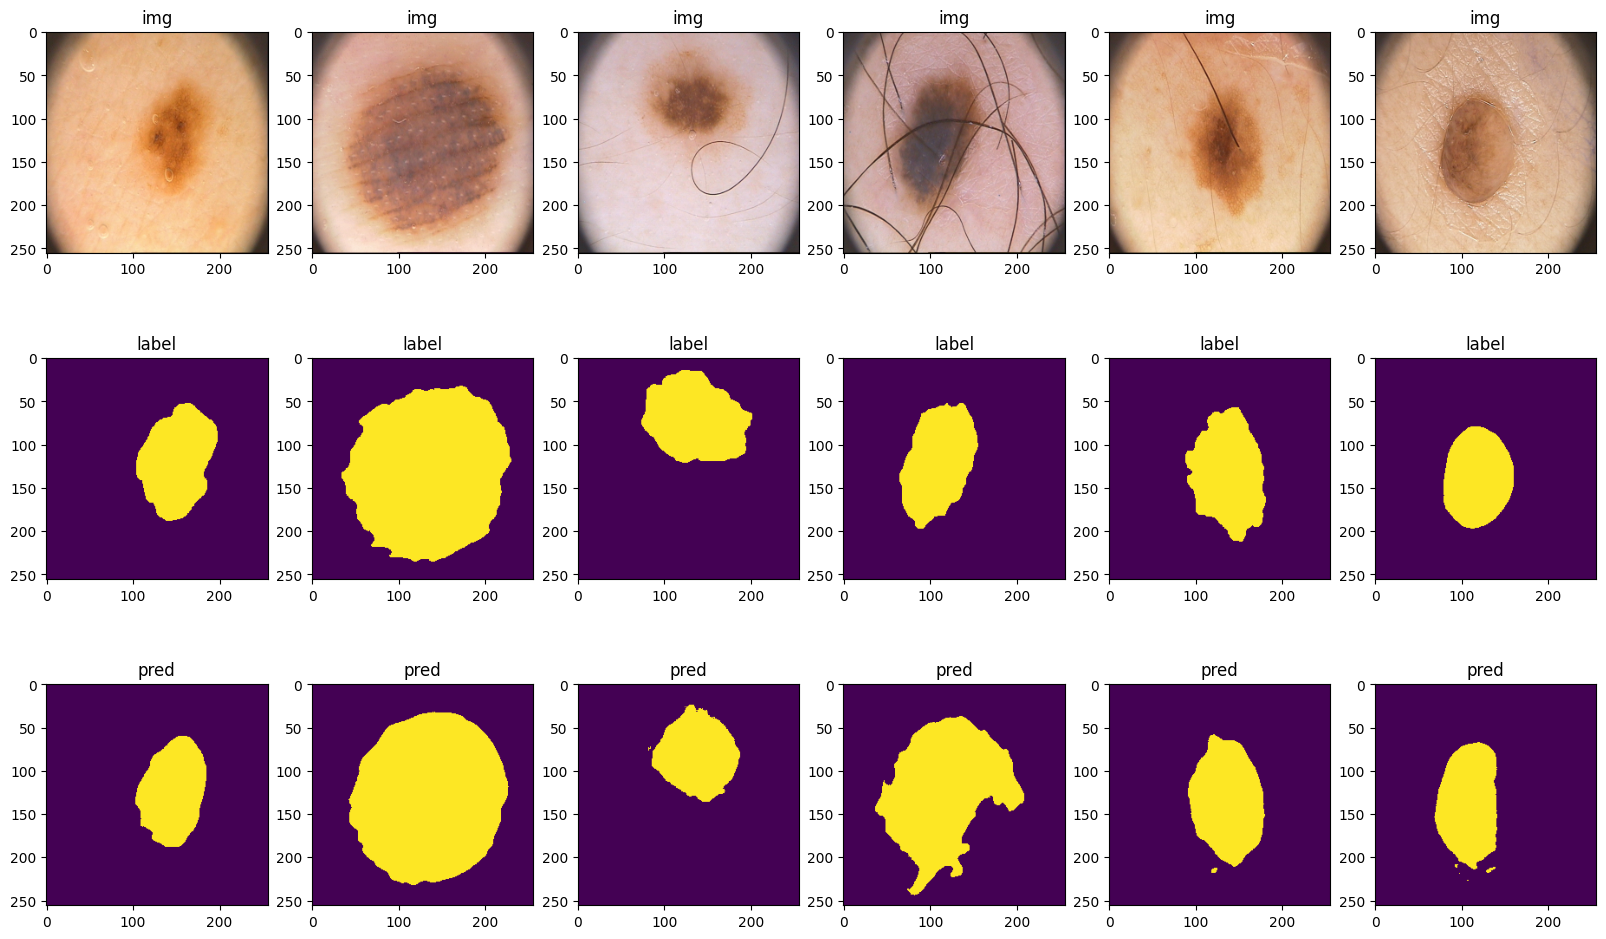

In [59]:
draw(segnet_model2, test_dataloader.dataset, verbose=True)

# FocalLoss

In [60]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

segnet_model3 = SegNet().to(device)
# print(segnet_model3)

# for module in segnet_model3.modules():
#     if isinstance(module, nn.BatchNorm2d):
#         module.eps = 1e-4

start_event = torch.cuda.Event(enable_timing=True)
end_event   = torch.cuda.Event(enable_timing=True)

optimizer = torch.optim.AdamW(segnet_model3.parameters(), lr=1e-3, weight_decay=1e-4)  # 1e-3 # 1.75e-3
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)
scaler    = torch.amp.GradScaler(device=device.type) 
early_stopping = EarlyStopping(patience=10, mode='min')
checkpointing  = CheckpointManager(limit=3, device=device.type)

experiment = 'criterion=SigmoidFocalLoss;batch_size=12;BatchNorm2d.eps=default;patience=5\\10;epochs=30;lr=1e-3'

config = {
    'model'         : segnet_model3,
    'trainloader'   : train_dataloader,
    'valloader'     : valid_dataloader,
    'criterion'     : SigmoidFocalLoss(reduction='mean'),
    'optimizer'     : optimizer,
    'scheduler'     : scheduler,
    'scaler'        : scaler,
    'early_stopping': early_stopping,
    'checkpointing' : checkpointing,
    'epochs'        : 30,
    'experiment'    : experiment,
    'use_amp'       : False,  # try turning off
    'writer_dir'    : 'summary',
    'device'        : device,
    'compile_flag'  : True
}

start_event.record()
train(**config) 
end_event.record()

torch.cuda.synchronize()
elapsed_ms = start_event.elapsed_time(end_event)

seconds = elapsed_ms/1000
minutes, leftover_seconds = seconds//60, seconds%60
print(f"Training took {minutes}m {leftover_seconds:.3f}s")

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:32:56 - INFO - [train]: epoch0, train loss: 0.09514034867286682
05-08-2025 13:32:56 - INFO - [train]: epoch0, val loss: 0.08558403134346008
05-08-2025 13:32:56 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/SegNet_epoch0000_13-32-56.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:33:02 - INFO - [train]: epoch1, train loss: 0.059525831937789916
05-08-2025 13:33:02 - INFO - [train]: epoch1, val loss: 0.06339731812477112
05-08-2025 13:33:02 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/SegNet_epoch0001_13-33-02.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:33:07 - INFO - [train]: epoch2, train loss: 0.046259374246001246
05-08-2025 13:33:07 - INFO - [train]: epoch2, val loss: 0.07252802908420562


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:33:13 - INFO - [train]: epoch3, train loss: 0.044536906406283376
05-08-2025 13:33:13 - INFO - [train]: epoch3, val loss: 0.2759582507610321


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:33:18 - INFO - [train]: epoch4, train loss: 0.04135297268629074
05-08-2025 13:33:18 - INFO - [train]: epoch4, val loss: 0.16863724410533906


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:33:24 - INFO - [train]: epoch5, train loss: 0.0394257864356041
05-08-2025 13:33:24 - INFO - [train]: epoch5, val loss: 0.08178247392177582


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:33:29 - INFO - [train]: epoch6, train loss: 0.03337350562214851
05-08-2025 13:33:29 - INFO - [train]: epoch6, val loss: 0.06751162171363831


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:33:34 - INFO - [train]: epoch7, train loss: 0.03118540994822979
05-08-2025 13:33:34 - INFO - [train]: epoch7, val loss: 0.03830369055271149
05-08-2025 13:33:35 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/SegNet_epoch0007_13-33-34.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:33:40 - INFO - [train]: epoch8, train loss: 0.03168032929301262
05-08-2025 13:33:40 - INFO - [train]: epoch8, val loss: 0.03612001322209835
05-08-2025 13:33:40 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/SegNet_epoch0008_13-33-40.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:33:46 - INFO - [train]: epoch9, train loss: 0.033484931960701944
05-08-2025 13:33:46 - INFO - [train]: epoch9, val loss: 0.06538693577051163


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:33:51 - INFO - [train]: epoch10, train loss: 0.033512094393372535
05-08-2025 13:33:51 - INFO - [train]: epoch10, val loss: 0.03831728026270866


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:33:57 - INFO - [train]: epoch11, train loss: 0.03080443598330021
05-08-2025 13:33:57 - INFO - [train]: epoch11, val loss: 0.05282024592161179


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:34:02 - INFO - [train]: epoch12, train loss: 0.031027682423591614
05-08-2025 13:34:02 - INFO - [train]: epoch12, val loss: 0.028391741514205933
05-08-2025 13:34:02 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/SegNet_epoch0012_13-34-02.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:34:08 - INFO - [train]: epoch13, train loss: 0.028819621130824088
05-08-2025 13:34:08 - INFO - [train]: epoch13, val loss: 0.04031522363424301


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:34:13 - INFO - [train]: epoch14, train loss: 0.027633508667349815
05-08-2025 13:34:13 - INFO - [train]: epoch14, val loss: 0.07149701312184334


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:34:18 - INFO - [train]: epoch15, train loss: 0.029135135263204576
05-08-2025 13:34:18 - INFO - [train]: epoch15, val loss: 0.029309582486748694


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:34:24 - INFO - [train]: epoch16, train loss: 0.029137924909591675
05-08-2025 13:34:24 - INFO - [train]: epoch16, val loss: 0.08432048082351684


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:34:29 - INFO - [train]: epoch17, train loss: 0.02778366133570671
05-08-2025 13:34:29 - INFO - [train]: epoch17, val loss: 0.027234439551830292
05-08-2025 13:34:30 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/SegNet_epoch0017_13-34-29.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:34:35 - INFO - [train]: epoch18, train loss: 0.02635623551905155
05-08-2025 13:34:35 - INFO - [train]: epoch18, val loss: 0.029494330137968063


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:34:40 - INFO - [train]: epoch19, train loss: 0.02736562393605709
05-08-2025 13:34:40 - INFO - [train]: epoch19, val loss: 0.02735952764749527


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:34:46 - INFO - [train]: epoch20, train loss: 0.027396477833390234
05-08-2025 13:34:46 - INFO - [train]: epoch20, val loss: 0.04474097259342671


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:34:51 - INFO - [train]: epoch21, train loss: 0.023281924538314343
05-08-2025 13:34:51 - INFO - [train]: epoch21, val loss: 0.02954128950834274


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:34:57 - INFO - [train]: epoch22, train loss: 0.026055525802075864
05-08-2025 13:34:57 - INFO - [train]: epoch22, val loss: 0.025737015008926393
05-08-2025 13:34:57 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/SegNet_epoch0022_13-34-57.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:35:02 - INFO - [train]: epoch23, train loss: 0.02731837198138237
05-08-2025 13:35:02 - INFO - [train]: epoch23, val loss: 0.03842724651098251


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:35:08 - INFO - [train]: epoch24, train loss: 0.032136303260922434
05-08-2025 13:35:08 - INFO - [train]: epoch24, val loss: 0.02853658691048622


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:35:13 - INFO - [train]: epoch25, train loss: 0.028486507683992385
05-08-2025 13:35:13 - INFO - [train]: epoch25, val loss: 0.02808873951435089


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:35:18 - INFO - [train]: epoch26, train loss: 0.0255975241959095
05-08-2025 13:35:18 - INFO - [train]: epoch26, val loss: 0.025431367754936218


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:35:24 - INFO - [train]: epoch27, train loss: 0.025145035088062286
05-08-2025 13:35:24 - INFO - [train]: epoch27, val loss: 0.023340002372860907
05-08-2025 13:35:24 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/SegNet_epoch0027_13-35-24.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:35:29 - INFO - [train]: epoch28, train loss: 0.02263117242604494
05-08-2025 13:35:29 - INFO - [train]: epoch28, val loss: 0.025503749102354048


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:35:35 - INFO - [train]: epoch29, train loss: 0.024791207015514374
05-08-2025 13:35:35 - INFO - [train]: epoch29, val loss: 0.02431858092546463
05-08-2025 13:35:35 - INFO - [train]: training done, loading best model at: checkpoint/05-08-2025/SegNet_epoch0027_13-35-24.pth


Training took 2.0m 44.164s


In [61]:
test(segnet_model3, test_dataloader, SigmoidFocalLoss(reduction='mean'), 'test_'+experiment, 
     writer_dir='summary', compile_flag=True, device='cuda', use_amp=False)


batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:35:36 - INFO - [test]: loss=0.020944307260215282, IoU=0.7500062584877014


/tmp/ipykernel_16052/1226885637.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  inp = np.array(inp)


idx: [ 1 49  5 43 29 28]


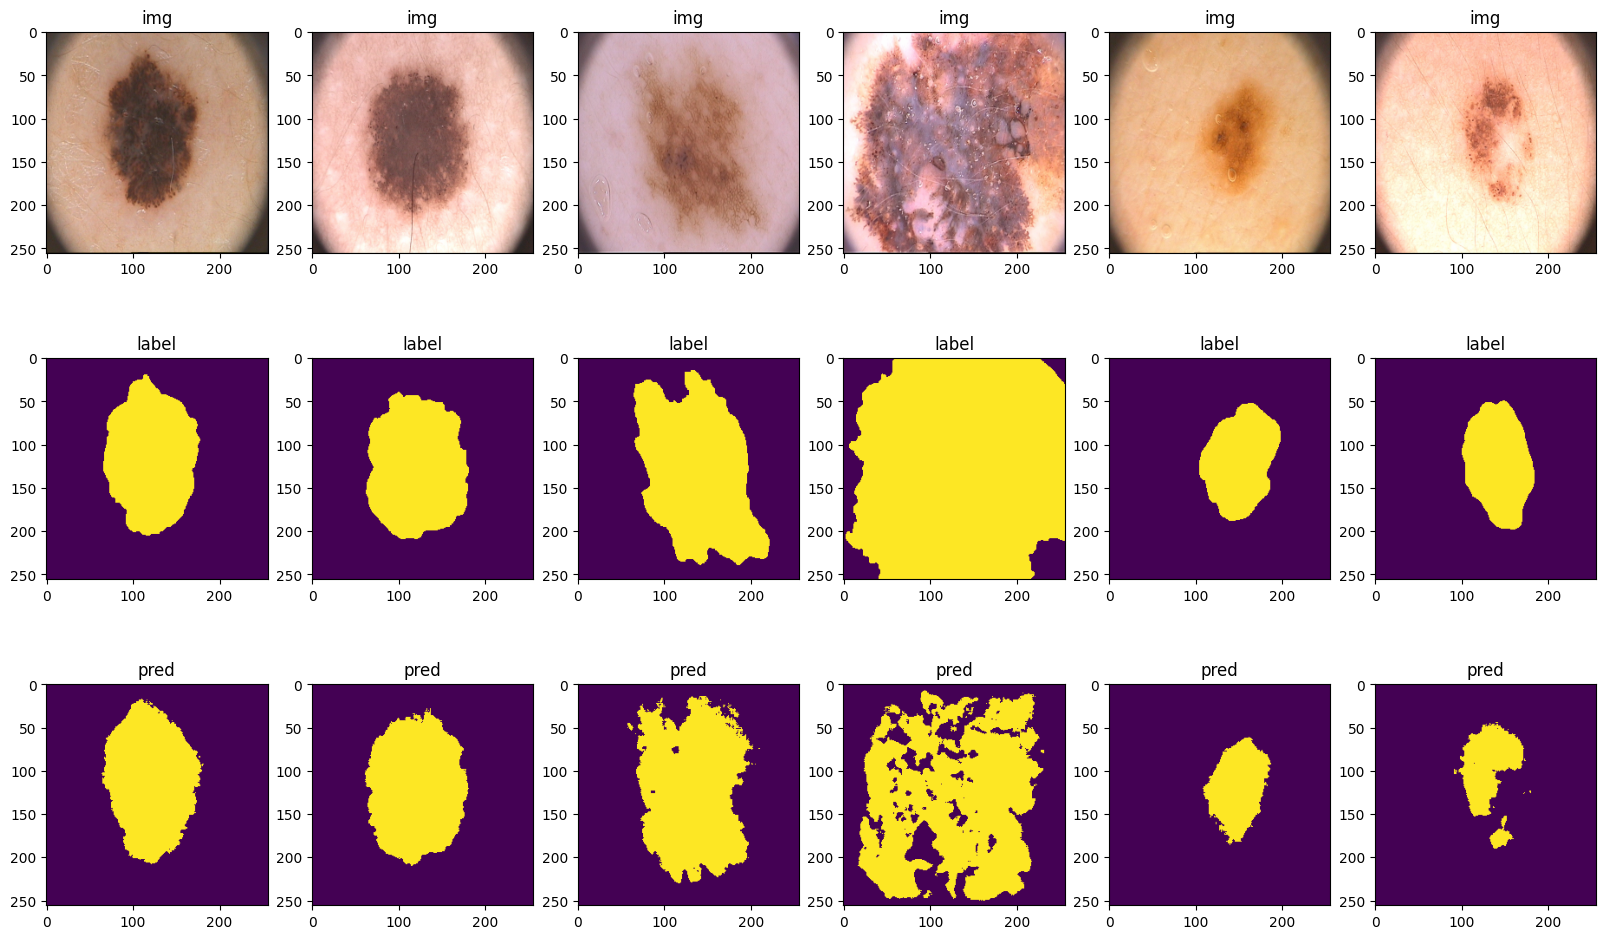

In [62]:
draw(segnet_model3, test_dataloader.dataset, verbose=True)

## U-Net

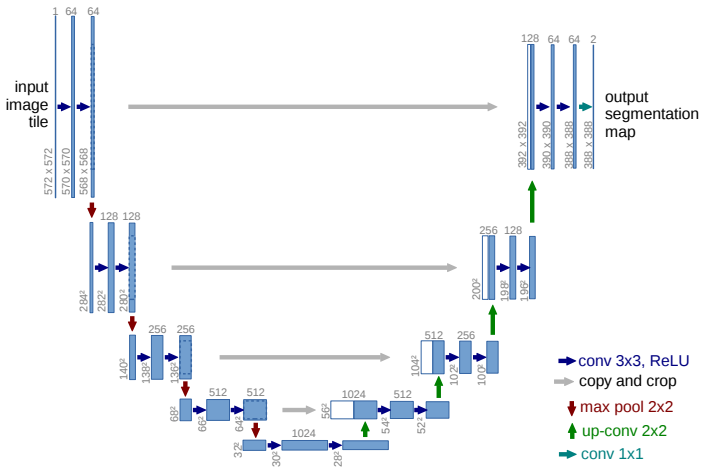

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [63]:
import torch.nn.functional as F
import torchvision.transforms.functional as F_CV
import torch.nn as nn

In [65]:
class UNet(nn.Module):
    class _EncoderBlock(nn.Module):        
        def __init__(self, in_channels, out_channels):
            super().__init__()

            self.block = nn.Sequential(
                nn.Conv2d(in_channels,  out_channels, 3, padding=1),
                nn.ReLU(),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.ReLU()
            )

            self.pool = nn.MaxPool2d(2, stride=2)
        
        def forward(self, x):
            x_pre  = self.block(x)
            x_post = self.pool(x_pre)
            return x_pre, x_post
    
    class _Encoder(nn.Module):
        def __init__(self, in_channels, n=4, base=64):
            super().__init__()

            self.blocks = nn.ModuleList()
            for i in range(n):
                in_channels  = in_channels if i == 0 else base*(2**(i-1))
                out_channels = base*(2**i)
                self.blocks.append(
                    UNet._EncoderBlock(in_channels, out_channels)
                )
        
        def forward(self, x):
            descent_hist = []
            for block in self.blocks:
                x_pre, x = block(x)
                descent_hist.append(x_pre)

            return x, descent_hist

    class _DecoderBlock(nn.Module):
        def __init__(self, in_channels, out_channels):
            super().__init__()

            self.up_conv = nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2)  # e.g. 1024 -> 512

            self.block = nn.Sequential(
                nn.Conv2d(in_channels,  out_channels, 3, padding=1),  # after concatenating we once again have 1024 channels
                nn.ReLU(),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.ReLU()
            )

        def forward(self, x, skip_connection):
            up = self.up_conv(x)

            # skip_cropped = F_CV.center_crop(skip_connection, output_size=up.shape[-2:])
            
            x  = torch.cat([skip_connection, up], dim=1)
            return self.block(x)

    class _Decoder(nn.Module):
        def __init__(self, in_channels, n=4):
            super().__init__()

            orig_in_channels = in_channels
            self.blocks = nn.ModuleList()
            for i in range(n):
                in_channels  = orig_in_channels if i == 0 else orig_in_channels // (2**(i))
                out_channels = orig_in_channels // (2**(i+1))
                self.blocks.append(
                    UNet._DecoderBlock(in_channels, out_channels)
                )

        def forward(self, x, descent_hist):
            for block, skip in zip(self.blocks, descent_hist[::-1]):
                x = block(x, skip)
            return x

    def __init__(self, in_channels=1, n_classes=2, n=4, base=64):
        super().__init__()
        
        self.encoder = self._Encoder(in_channels=in_channels, n=n, base=base)

        enc_out = base * (2 ** (n-1))  # e.g., 512 when n=4
        bottleneck_in  = enc_out
        bottleneck_out = enc_out * 2   # e.g., 1024

        self.bottleneck = nn.Sequential(
            nn.Conv2d(bottleneck_in,  bottleneck_out, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(bottleneck_out, bottleneck_out, 3, padding=1),
            nn.ReLU()
        )

        self.decoder = self._Decoder(in_channels=bottleneck_out, n=n)

        self.classifier = nn.Conv2d(base, n_classes, 1)

    def forward(self, x):
        e, descent_hist = self.encoder(x)
        b = self.bottleneck(e)
        d = self.decoder(b, descent_hist)
        
        output = self.classifier(d)
        return output


In [66]:
unet_model = UNet(in_channels=3, n_classes=1).to(device)
print(unet_model)

UNet(
  (encoder): _Encoder(
    (blocks): ModuleList(
      (0): _EncoderBlock(
        (block): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU()
        )
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): _EncoderBlock(
        (block): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU()
        )
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (2): _EncoderBlock(
        (block): Sequential(
          (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
          (2): Conv2d(256, 256, kernel_size

## Обучим UNet

# BCEWithLogitsLoss

In [67]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

unet_model1 = UNet(in_channels=3, n_classes=1).to(device)
# print(unet_model1)

start_event = torch.cuda.Event(enable_timing=True)
end_event   = torch.cuda.Event(enable_timing=True)

optimizer = torch.optim.AdamW(unet_model1.parameters(), lr=1e-3, weight_decay=1e-4)  # 1e-3 # 1.75e-3
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)
scaler    = torch.amp.GradScaler(device=device.type) 
early_stopping = EarlyStopping(patience=10, mode='min')
checkpointing  = CheckpointManager(limit=3, device=device.type)

experiment = 'model=UNet;criterion=BCEWithLogitsLoss;batch_size=12;patience=5\\10;epochs=30;lr=1e-3'

config = {
    'model'         : unet_model1,
    'trainloader'   : train_dataloader,
    'valloader'     : valid_dataloader,
    'criterion'     : nn.BCEWithLogitsLoss(),
    'optimizer'     : optimizer,
    'scheduler'     : scheduler,
    'scaler'        : scaler,
    'early_stopping': early_stopping,
    'checkpointing' : checkpointing,
    'epochs'        : 30,
    'experiment'    : experiment,
    'use_amp'       : False,  # try turning off
    'writer_dir'    : 'summary',
    'device'        : device,
    'compile_flag'  : True
}

start_event.record()
train(**config) 
end_event.record()

torch.cuda.synchronize()
elapsed_ms = start_event.elapsed_time(end_event)

seconds = elapsed_ms/1000
minutes, leftover_seconds = seconds//60, seconds%60
print(f"Training took {minutes}m {leftover_seconds:.3f}s")

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:35:48 - INFO - [train]: epoch0, train loss: 0.6396514630317688
05-08-2025 13:35:48 - INFO - [train]: epoch0, val loss: 0.5939470076560974
05-08-2025 13:35:48 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/UNet_epoch0000_13-35-48.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:35:55 - INFO - [train]: epoch1, train loss: 0.5660070276260376
05-08-2025 13:35:55 - INFO - [train]: epoch1, val loss: 0.5639592397212982
05-08-2025 13:35:55 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/UNet_epoch0001_13-35-55.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:36:03 - INFO - [train]: epoch2, train loss: 0.5225742173194885
05-08-2025 13:36:03 - INFO - [train]: epoch2, val loss: 0.4900410532951355
05-08-2025 13:36:03 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/UNet_epoch0002_13-36-03.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:36:10 - INFO - [train]: epoch3, train loss: 0.47284955620765684
05-08-2025 13:36:10 - INFO - [train]: epoch3, val loss: 0.4666790008544922
05-08-2025 13:36:11 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/UNet_epoch0003_13-36-10.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:36:18 - INFO - [train]: epoch4, train loss: 0.4689110541343689
05-08-2025 13:36:18 - INFO - [train]: epoch4, val loss: 0.456837066411972
05-08-2025 13:36:18 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/UNet_epoch0004_13-36-18.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:36:26 - INFO - [train]: epoch5, train loss: 0.44360033273696897
05-08-2025 13:36:26 - INFO - [train]: epoch5, val loss: 0.4554893469810486
05-08-2025 13:36:26 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/UNet_epoch0005_13-36-26.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:36:33 - INFO - [train]: epoch6, train loss: 0.45200459480285643
05-08-2025 13:36:33 - INFO - [train]: epoch6, val loss: 0.38296629428863527
05-08-2025 13:36:34 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/UNet_epoch0006_13-36-33.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:36:41 - INFO - [train]: epoch7, train loss: 0.44365143656730655
05-08-2025 13:36:41 - INFO - [train]: epoch7, val loss: 0.35773860454559325
05-08-2025 13:36:42 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/UNet_epoch0007_13-36-41.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:36:49 - INFO - [train]: epoch8, train loss: 0.33342211425304413
05-08-2025 13:36:49 - INFO - [train]: epoch8, val loss: 0.556290875673294


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:36:56 - INFO - [train]: epoch9, train loss: 0.5304157161712646
05-08-2025 13:36:56 - INFO - [train]: epoch9, val loss: 0.5582707333564758


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:37:04 - INFO - [train]: epoch10, train loss: 0.39136459946632385
05-08-2025 13:37:04 - INFO - [train]: epoch10, val loss: 0.3498702502250671
05-08-2025 13:37:04 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/UNet_epoch0010_13-37-04.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:37:11 - INFO - [train]: epoch11, train loss: 0.44025166690349576
05-08-2025 13:37:11 - INFO - [train]: epoch11, val loss: 0.3509771126508713


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:37:19 - INFO - [train]: epoch12, train loss: 0.34855165004730226
05-08-2025 13:37:19 - INFO - [train]: epoch12, val loss: 0.37498961567878725


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:37:26 - INFO - [train]: epoch13, train loss: 8.76335945725441
05-08-2025 13:37:26 - INFO - [train]: epoch13, val loss: 0.346135618686676
05-08-2025 13:37:26 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/UNet_epoch0013_13-37-26.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:37:34 - INFO - [train]: epoch14, train loss: 1.3686289238929747
05-08-2025 13:37:34 - INFO - [train]: epoch14, val loss: 0.40207168102264407


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:37:41 - INFO - [train]: epoch15, train loss: 0.3558634305000305
05-08-2025 13:37:41 - INFO - [train]: epoch15, val loss: 0.35792728304862975


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:37:48 - INFO - [train]: epoch16, train loss: 0.3057644486427307
05-08-2025 13:37:48 - INFO - [train]: epoch16, val loss: 0.3308792555332184
05-08-2025 13:37:49 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/UNet_epoch0016_13-37-48.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:37:56 - INFO - [train]: epoch17, train loss: 0.3281765657663345
05-08-2025 13:37:56 - INFO - [train]: epoch17, val loss: 0.34734761238098144


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:38:03 - INFO - [train]: epoch18, train loss: 0.30350170731544496
05-08-2025 13:38:03 - INFO - [train]: epoch18, val loss: 0.3640315270423889


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:38:11 - INFO - [train]: epoch19, train loss: 0.2877336204051971
05-08-2025 13:38:11 - INFO - [train]: epoch19, val loss: 0.36637560129165647


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:38:18 - INFO - [train]: epoch20, train loss: 0.28792155146598813
05-08-2025 13:38:18 - INFO - [train]: epoch20, val loss: 0.36243913173675535


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:38:25 - INFO - [train]: epoch21, train loss: 0.284461749792099
05-08-2025 13:38:25 - INFO - [train]: epoch21, val loss: 0.45766672253608703


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:38:33 - INFO - [train]: epoch22, train loss: 0.2788048648834229
05-08-2025 13:38:33 - INFO - [train]: epoch22, val loss: 0.3271327269077301
05-08-2025 13:38:33 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/UNet_epoch0022_13-38-33.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:38:40 - INFO - [train]: epoch23, train loss: 0.26118184030056
05-08-2025 13:38:40 - INFO - [train]: epoch23, val loss: 0.31223958253860473
05-08-2025 13:38:41 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/UNet_epoch0023_13-38-40.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:38:48 - INFO - [train]: epoch24, train loss: 0.30383528530597687
05-08-2025 13:38:48 - INFO - [train]: epoch24, val loss: 0.5783961725234985


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:38:55 - INFO - [train]: epoch25, train loss: 0.30873833239078524
05-08-2025 13:38:55 - INFO - [train]: epoch25, val loss: 0.30955497741699217
05-08-2025 13:38:56 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/UNet_epoch0025_13-38-55.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:39:03 - INFO - [train]: epoch26, train loss: 0.24290780127048492
05-08-2025 13:39:03 - INFO - [train]: epoch26, val loss: 0.364076771736145


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:39:10 - INFO - [train]: epoch27, train loss: 0.2565992295742035
05-08-2025 13:39:10 - INFO - [train]: epoch27, val loss: 0.2697590911388397
05-08-2025 13:39:11 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/UNet_epoch0027_13-39-10.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:39:18 - INFO - [train]: epoch28, train loss: 0.24812550514936446
05-08-2025 13:39:18 - INFO - [train]: epoch28, val loss: 0.2557006439566612
05-08-2025 13:39:18 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/UNet_epoch0028_13-39-18.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:39:26 - INFO - [train]: epoch29, train loss: 0.210659139752388
05-08-2025 13:39:26 - INFO - [train]: epoch29, val loss: 0.3806412649154663
05-08-2025 13:39:26 - INFO - [train]: training done, loading best model at: checkpoint/05-08-2025/UNet_epoch0028_13-39-18.pth


Training took 3.0m 47.731s


In [68]:
test(unet_model1, test_dataloader, nn.BCEWithLogitsLoss(), 'test_'+experiment, 
     writer_dir='summary', compile_flag=True, device='cuda', use_amp=False)


batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:39:27 - INFO - [test]: loss=0.23376532316207885, IoU=0.7288416624069214


idx: [49 16 20 40 13 17]


/tmp/ipykernel_16052/1226885637.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  inp = np.array(inp)


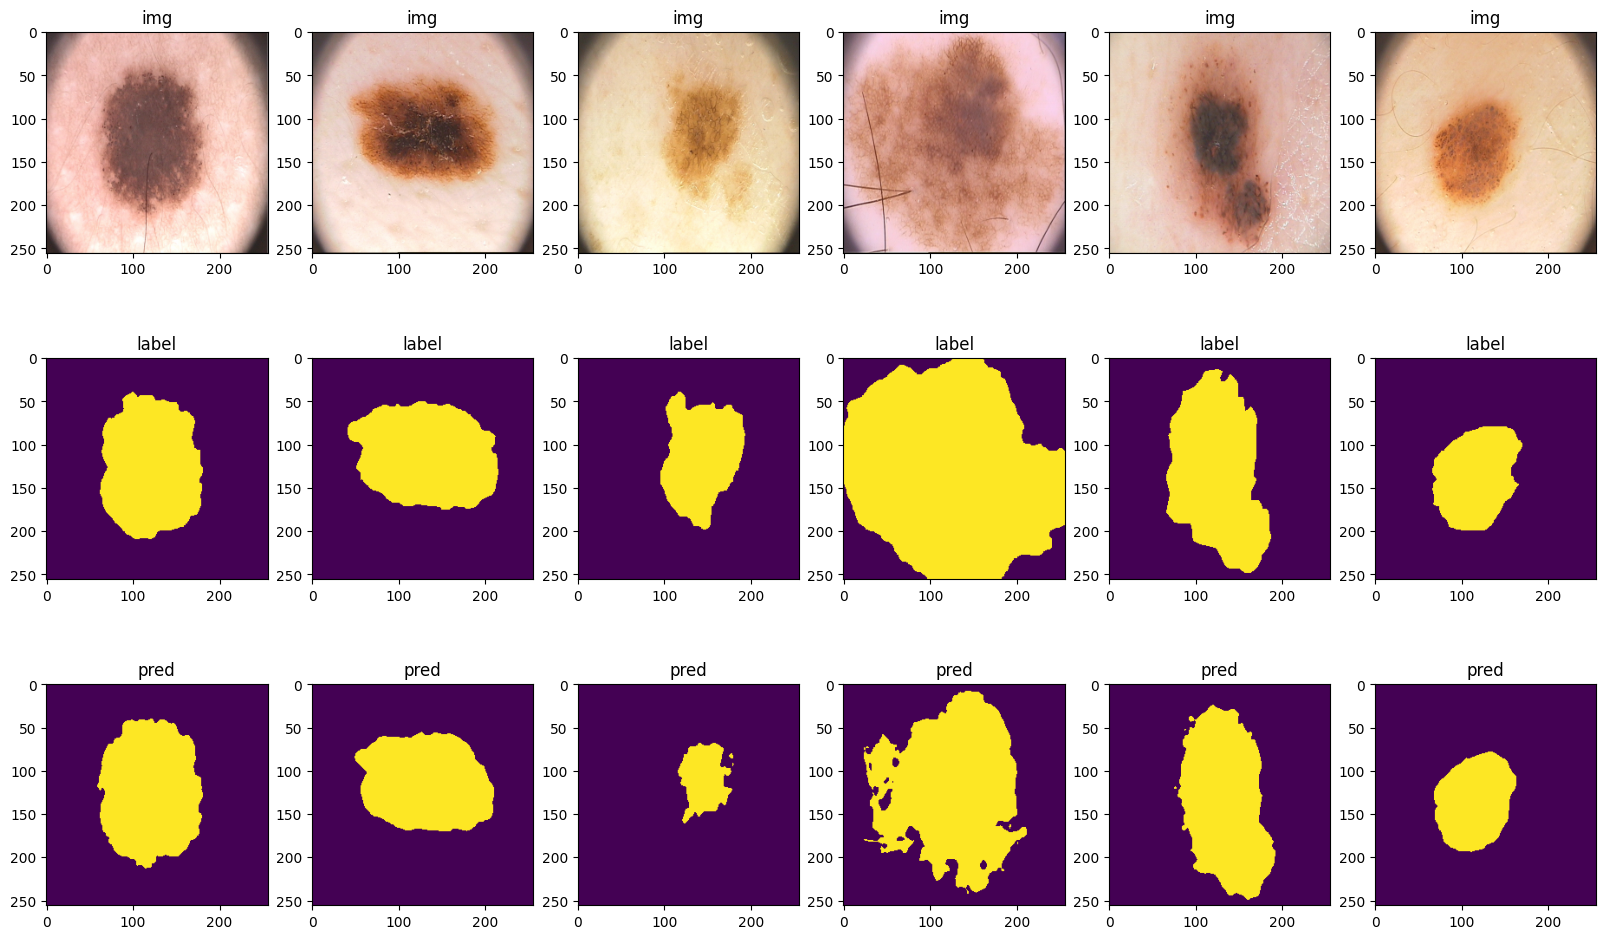

In [69]:
draw(unet_model1, test_dataloader.dataset, verbose=True)

# DiceLoss

In [70]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

unet_model2 = UNet(in_channels=3, n_classes=1).to(device)
# print(unet_model2)

start_event = torch.cuda.Event(enable_timing=True)
end_event   = torch.cuda.Event(enable_timing=True)

optimizer = torch.optim.AdamW(unet_model2.parameters(), lr=1e-3, weight_decay=1e-4)  # 1e-3 # 1.75e-3
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)
scaler    = torch.amp.GradScaler(device=device.type) 
early_stopping = EarlyStopping(patience=10, mode='min')
checkpointing  = CheckpointManager(limit=3, device=device.type)

experiment = 'model=UNet;criterion=DiceLoss;batch_size=12;patience=5\\10;epochs=30;lr=1e-3'

config = {
    'model'         : unet_model2,
    'trainloader'   : train_dataloader,
    'valloader'     : valid_dataloader,
    'criterion'     : DiceLoss(mode='binary'),
    'optimizer'     : optimizer,
    'scheduler'     : scheduler,
    'scaler'        : scaler,
    'early_stopping': early_stopping,
    'checkpointing' : checkpointing,
    'epochs'        : 30,
    'experiment'    : experiment,
    'use_amp'       : False,  # try turning off
    'writer_dir'    : 'summary',
    'device'        : device,
    'compile_flag'  : True
}

start_event.record()
train(**config) 
end_event.record()

torch.cuda.synchronize()
elapsed_ms = start_event.elapsed_time(end_event)

seconds = elapsed_ms/1000
minutes, leftover_seconds = seconds//60, seconds%60
print(f"Training took {minutes}m {leftover_seconds:.3f}s")

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:39:37 - INFO - [train]: epoch0, train loss: 0.5658245873451233
05-08-2025 13:39:37 - INFO - [train]: epoch0, val loss: 0.4970705223083496
05-08-2025 13:39:38 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/UNet_epoch0000_13-39-37.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:39:45 - INFO - [train]: epoch1, train loss: 0.5209315729141235
05-08-2025 13:39:45 - INFO - [train]: epoch1, val loss: 0.49453317880630493
05-08-2025 13:39:45 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/UNet_epoch0001_13-39-45.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:39:52 - INFO - [train]: epoch2, train loss: 0.5203932428359985
05-08-2025 13:39:52 - INFO - [train]: epoch2, val loss: 0.4941601943969727


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:40:00 - INFO - [train]: epoch3, train loss: 0.5199532866477966
05-08-2025 13:40:00 - INFO - [train]: epoch3, val loss: 0.49314103841781615
05-08-2025 13:40:00 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/UNet_epoch0003_13-40-00.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:40:07 - INFO - [train]: epoch4, train loss: 0.5201704406738281
05-08-2025 13:40:07 - INFO - [train]: epoch4, val loss: 0.4964837336540222


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:40:15 - INFO - [train]: epoch5, train loss: 0.5219710755348206
05-08-2025 13:40:15 - INFO - [train]: epoch5, val loss: 0.49643969774246216


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:40:22 - INFO - [train]: epoch6, train loss: 0.5178883838653564
05-08-2025 13:40:22 - INFO - [train]: epoch6, val loss: 0.4956143021583557


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:40:29 - INFO - [train]: epoch7, train loss: 0.5199129915237427
05-08-2025 13:40:29 - INFO - [train]: epoch7, val loss: 0.4970244884490967


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:40:36 - INFO - [train]: epoch8, train loss: 0.5210704207420349
05-08-2025 13:40:36 - INFO - [train]: epoch8, val loss: 0.49843780517578123


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:40:44 - INFO - [train]: epoch9, train loss: 0.5194980192184449
05-08-2025 13:40:44 - INFO - [train]: epoch9, val loss: 0.49433199167251585


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:40:51 - INFO - [train]: epoch10, train loss: 0.5216029357910156
05-08-2025 13:40:51 - INFO - [train]: epoch10, val loss: 0.49675978899002077


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:40:58 - INFO - [train]: epoch11, train loss: 0.5207612943649292
05-08-2025 13:40:58 - INFO - [train]: epoch11, val loss: 0.4963377976417542


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:41:06 - INFO - [train]: epoch12, train loss: 0.5190504336357117
05-08-2025 13:41:06 - INFO - [train]: epoch12, val loss: 0.49965174913406374


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:41:13 - INFO - [train]: epoch13, train loss: 0.5202127885818482
05-08-2025 13:41:13 - INFO - [train]: epoch13, val loss: 0.4939364838600159
05-08-2025 13:41:13 - INFO - [EarlyStopping] Reached plateau, stopping...
05-08-2025 13:41:13 - INFO - [train]: early stopping triggered
05-08-2025 13:41:13 - INFO - [train]: training done, loading best model at: checkpoint/05-08-2025/UNet_epoch0003_13-40-00.pth


Training took 1.0m 43.319s


In [71]:
test(unet_model2, test_dataloader, DiceLoss(mode='binary'), 'test_'+experiment, 
     writer_dir='summary', compile_flag=True, device='cuda', use_amp=False)


batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:41:15 - INFO - [test]: loss=0.5268322587013244, IoU=0.31284117698669434


/tmp/ipykernel_16052/1226885637.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  inp = np.array(inp)


idx: [35  6 29 14 13  7]


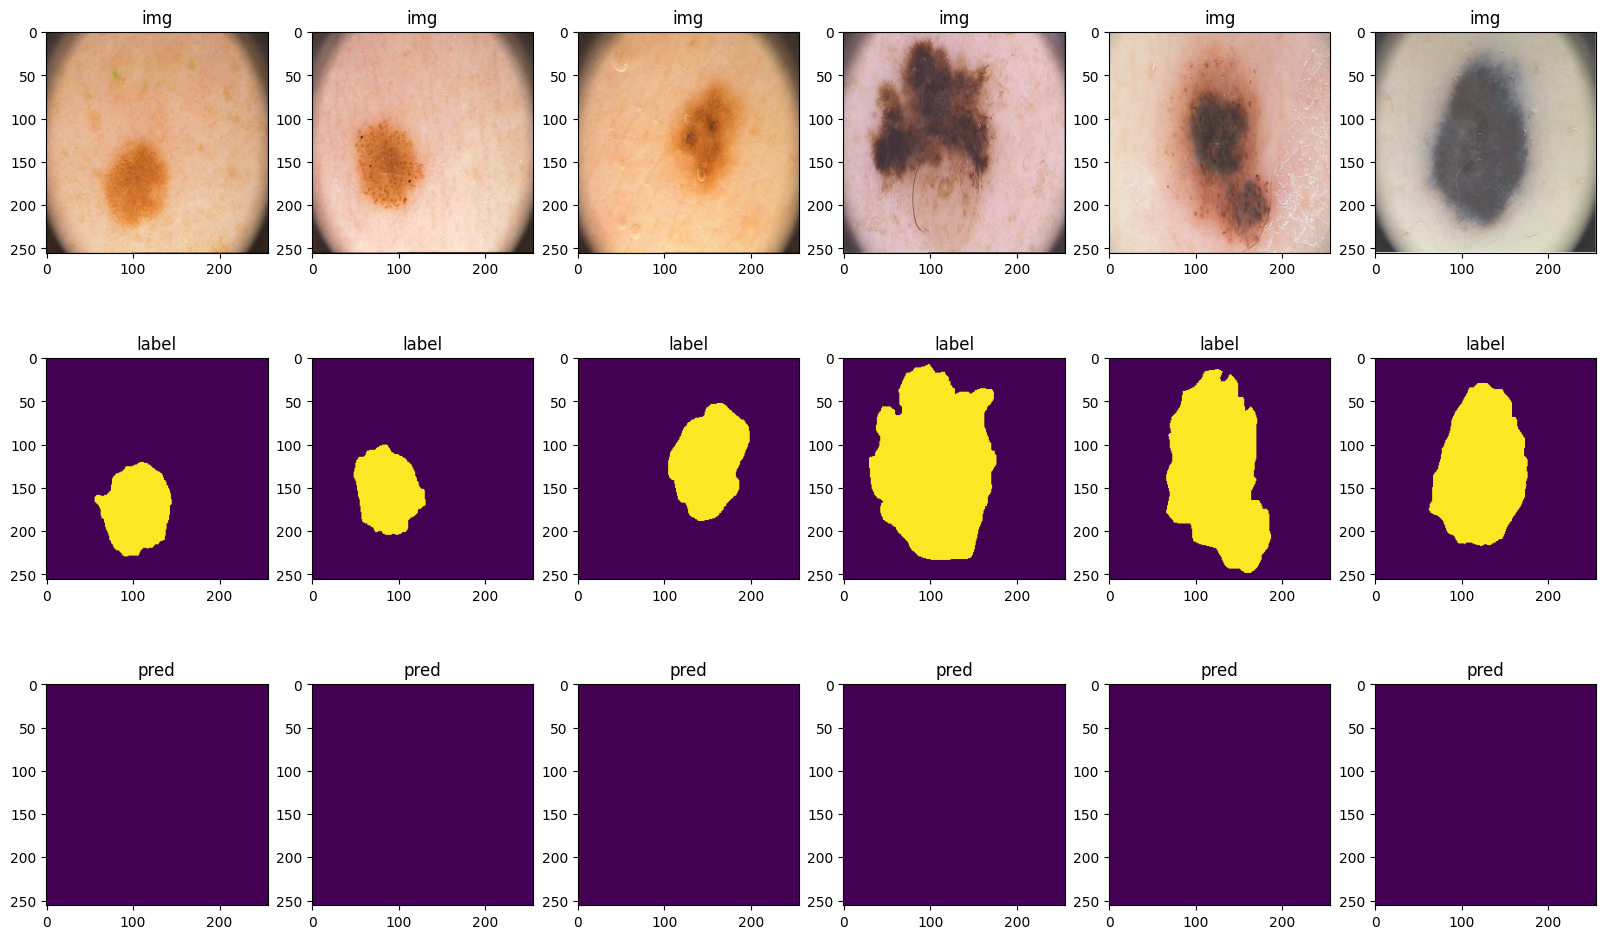

In [72]:
draw(unet_model2, test_dataloader.dataset, verbose=True)

# FocalLoss

In [73]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

unet_model3 = UNet(in_channels=3, n_classes=1).to(device)
# print(unet_model3)

start_event = torch.cuda.Event(enable_timing=True)
end_event   = torch.cuda.Event(enable_timing=True)

optimizer = torch.optim.AdamW(unet_model3.parameters(), lr=1e-3, weight_decay=1e-4)  # 1e-3 # 1.75e-3
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)
scaler    = torch.amp.GradScaler(device=device.type) 
early_stopping = EarlyStopping(patience=10, mode='min')
checkpointing  = CheckpointManager(limit=3, device=device.type)

experiment = 'model=UNet;criterion=SigmoidFocalLoss;batch_size=12;patience=5\\10;epochs=30;lr=1e-3'

config = {
    'model'         : unet_model3,
    'trainloader'   : train_dataloader,
    'valloader'     : valid_dataloader,
    'criterion'     : SigmoidFocalLoss(reduction='mean'),
    'optimizer'     : optimizer,
    'scheduler'     : scheduler,
    'scaler'        : scaler,
    'early_stopping': early_stopping,
    'checkpointing' : checkpointing,
    'epochs'        : 30,
    'experiment'    : experiment,
    'use_amp'       : False,  # try turning off
    'writer_dir'    : 'summary',
    'device'        : device,
    'compile_flag'  : True
}

start_event.record()
train(**config) 
end_event.record()

torch.cuda.synchronize()
elapsed_ms = start_event.elapsed_time(end_event)

seconds = elapsed_ms/1000
minutes, leftover_seconds = seconds//60, seconds%60
print(f"Training took {minutes}m {leftover_seconds:.3f}s")

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:41:24 - INFO - [train]: epoch0, train loss: 0.06832271367311478
05-08-2025 13:41:24 - INFO - [train]: epoch0, val loss: 0.05459381580352783
05-08-2025 13:41:24 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/UNet_epoch0000_13-41-24.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:41:32 - INFO - [train]: epoch1, train loss: 0.052478711605072025
05-08-2025 13:41:32 - INFO - [train]: epoch1, val loss: 0.050825965404510495
05-08-2025 13:41:32 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/UNet_epoch0001_13-41-32.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:41:39 - INFO - [train]: epoch2, train loss: 0.04741000026464462
05-08-2025 13:41:39 - INFO - [train]: epoch2, val loss: 0.04510558128356933
05-08-2025 13:41:40 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/UNet_epoch0002_13-41-39.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:41:47 - INFO - [train]: epoch3, train loss: 0.047773975282907485
05-08-2025 13:41:47 - INFO - [train]: epoch3, val loss: 0.04435360729694367


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:41:54 - INFO - [train]: epoch4, train loss: 0.043738692700862884
05-08-2025 13:41:54 - INFO - [train]: epoch4, val loss: 0.04303805574774742
05-08-2025 13:41:55 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/UNet_epoch0004_13-41-54.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:42:02 - INFO - [train]: epoch5, train loss: 0.04135869264602661
05-08-2025 13:42:02 - INFO - [train]: epoch5, val loss: 0.04208387494087219


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:42:10 - INFO - [train]: epoch6, train loss: 0.04120896756649017
05-08-2025 13:42:10 - INFO - [train]: epoch6, val loss: 0.06285547994077206


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:42:17 - INFO - [train]: epoch7, train loss: 0.056482629030942914
05-08-2025 13:42:17 - INFO - [train]: epoch7, val loss: 0.042588476240634915


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:42:24 - INFO - [train]: epoch8, train loss: 0.042908205091953276
05-08-2025 13:42:24 - INFO - [train]: epoch8, val loss: 0.042379582524299624


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:42:32 - INFO - [train]: epoch9, train loss: 0.03913528621196747
05-08-2025 13:42:32 - INFO - [train]: epoch9, val loss: 0.04169319704174995
05-08-2025 13:42:32 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/UNet_epoch0009_13-42-32.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:42:39 - INFO - [train]: epoch10, train loss: 0.03965998597443104
05-08-2025 13:42:39 - INFO - [train]: epoch10, val loss: 0.04283297002315521


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:42:47 - INFO - [train]: epoch11, train loss: 0.037718137875199315
05-08-2025 13:42:47 - INFO - [train]: epoch11, val loss: 0.03743102751672268
05-08-2025 13:42:47 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/UNet_epoch0011_13-42-47.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:42:54 - INFO - [train]: epoch12, train loss: 0.03588311657309532
05-08-2025 13:42:54 - INFO - [train]: epoch12, val loss: 0.0424410355091095


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:43:02 - INFO - [train]: epoch13, train loss: 0.0377911688387394
05-08-2025 13:43:02 - INFO - [train]: epoch13, val loss: 0.042995298206806185


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:43:09 - INFO - [train]: epoch14, train loss: 0.035533417165279385
05-08-2025 13:43:09 - INFO - [train]: epoch14, val loss: 0.03662857219576836


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:43:16 - INFO - [train]: epoch15, train loss: 0.033887215182185175
05-08-2025 13:43:16 - INFO - [train]: epoch15, val loss: 0.04102808564901352


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:43:24 - INFO - [train]: epoch16, train loss: 0.03402421854436397
05-08-2025 13:43:24 - INFO - [train]: epoch16, val loss: 0.036878449022769925


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:43:31 - INFO - [train]: epoch17, train loss: 0.04813112080097198
05-08-2025 13:43:31 - INFO - [train]: epoch17, val loss: 0.0366375832259655


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:43:38 - INFO - [train]: epoch18, train loss: 0.033475767001509664
05-08-2025 13:43:38 - INFO - [train]: epoch18, val loss: 0.0421216569840908


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:43:46 - INFO - [train]: epoch19, train loss: 0.03429915308952332
05-08-2025 13:43:46 - INFO - [train]: epoch19, val loss: 0.03572028204798698
05-08-2025 13:43:46 - INFO - [CheckpointSaver] Saved model to checkpoint/05-08-2025/UNet_epoch0019_13-43-46.pth.


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:43:53 - INFO - [train]: epoch20, train loss: 0.03343827903270721
05-08-2025 13:43:53 - INFO - [train]: epoch20, val loss: 0.04127330332994461


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:44:01 - INFO - [train]: epoch21, train loss: 0.04117756813764572
05-08-2025 13:44:01 - INFO - [train]: epoch21, val loss: 0.5476396656036377


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:44:08 - INFO - [train]: epoch22, train loss: 0.06005411595106125
05-08-2025 13:44:08 - INFO - [train]: epoch22, val loss: 0.04045764327049255


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:44:15 - INFO - [train]: epoch23, train loss: 0.4610480684041977
05-08-2025 13:44:15 - INFO - [train]: epoch23, val loss: 0.04650349035859108


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:44:23 - INFO - [train]: epoch24, train loss: 0.034012823700904846
05-08-2025 13:44:23 - INFO - [train]: epoch24, val loss: 0.04547174394130707


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:44:30 - INFO - [train]: epoch25, train loss: 0.03401548333466053
05-08-2025 13:44:30 - INFO - [train]: epoch25, val loss: 0.045651125311851504


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:44:37 - INFO - [train]: epoch26, train loss: 0.034048078060150144
05-08-2025 13:44:37 - INFO - [train]: epoch26, val loss: 0.039162682518362996


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:44:45 - INFO - [train]: epoch27, train loss: 0.03133607745170593
05-08-2025 13:44:45 - INFO - [train]: epoch27, val loss: 0.03551980033516884


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:44:52 - INFO - [train]: epoch28, train loss: 0.031211722716689108
05-08-2025 13:44:52 - INFO - [train]: epoch28, val loss: 0.03593451380729675


batch:   0%|          | 0/9 [00:00<?, ?it/s]

batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:44:59 - INFO - [train]: epoch29, train loss: 0.03006810449063778
05-08-2025 13:44:59 - INFO - [train]: epoch29, val loss: 0.039218949377536776
05-08-2025 13:44:59 - INFO - [EarlyStopping] Reached plateau, stopping...
05-08-2025 13:44:59 - INFO - [train]: early stopping triggered
05-08-2025 13:44:59 - INFO - [train]: training done, loading best model at: checkpoint/05-08-2025/UNet_epoch0019_13-43-46.pth


Training took 3.0m 42.874s


In [74]:
test(unet_model3, test_dataloader, SigmoidFocalLoss(reduction='mean'), 'test_'+experiment, 
     writer_dir='summary', compile_flag=True, device='cuda', use_amp=False)


batch:   0%|          | 0/5 [00:00<?, ?it/s]

05-08-2025 13:45:01 - INFO - [test]: loss=0.029123373180627823, IoU=0.5258535146713257


/tmp/ipykernel_16052/1226885637.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  inp = np.array(inp)


idx: [35 28 12 16 48 26]


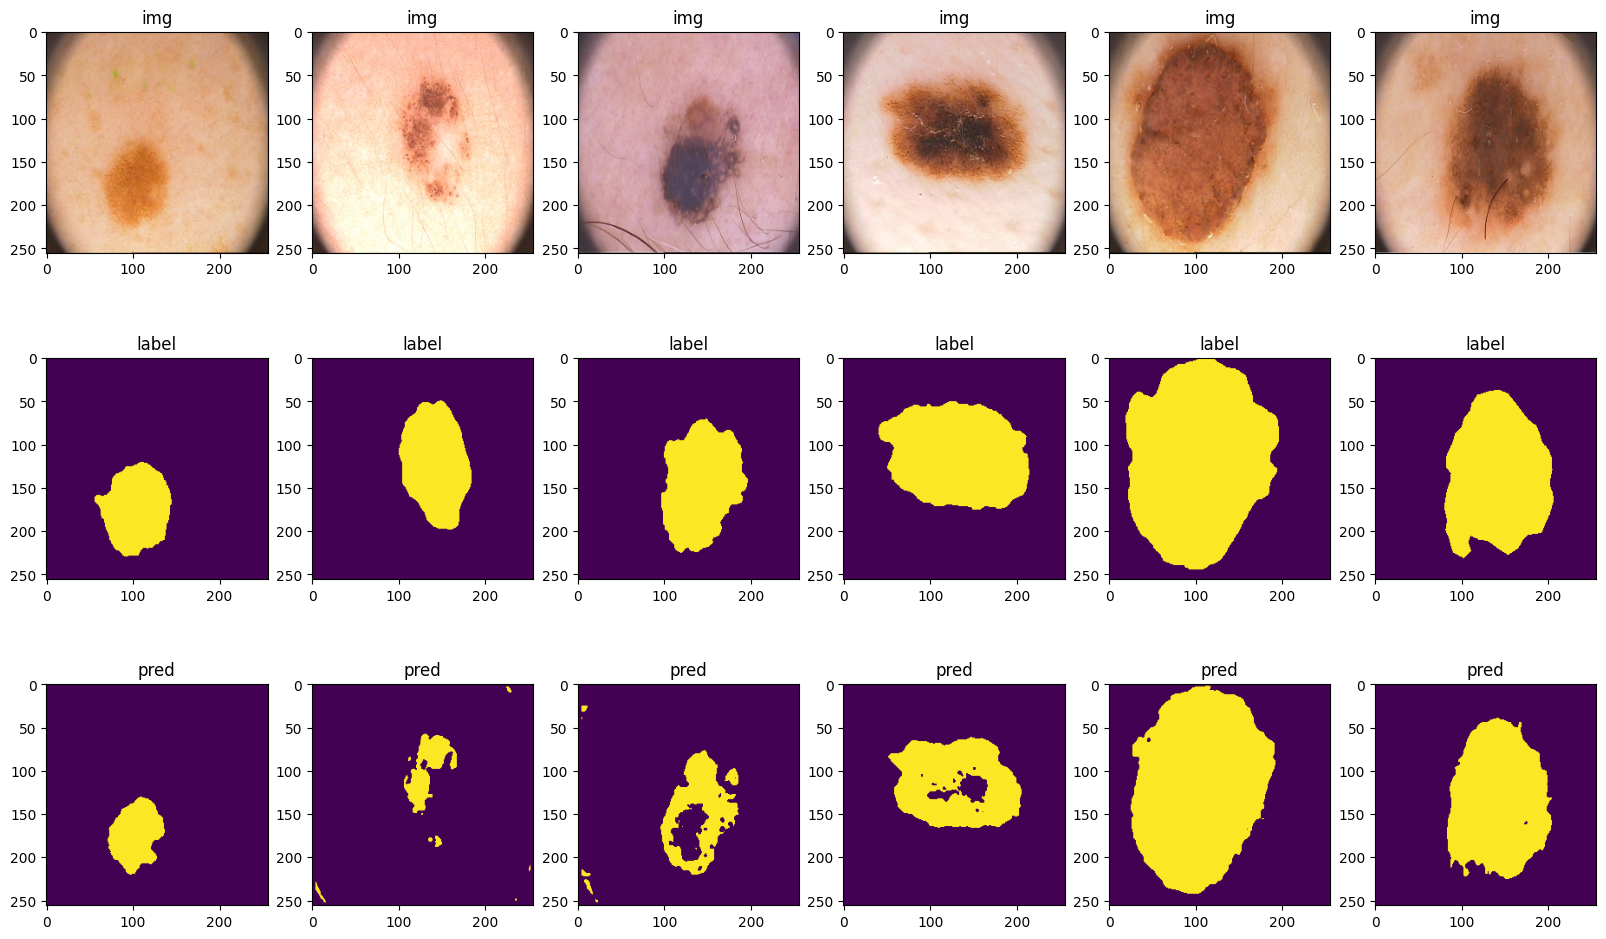

In [75]:
draw(unet_model3, test_dataloader.dataset, verbose=True)

результаты:

```python
SEGNET: {
    optimizer      : AdamW(lr=1e-3, weight_decay=1e-4)
    scheduler      : ReduceLROnPlateau(patience=5)
    scaler         : GradScaler
    early_stopping : EarlyStopping(patience=10, mode='min')
    epochs         : 30,
    batch_size     : 12
}

BCEWithLogitsLoss(): 
train loss: 0.21880828380584716
val   loss: 0.23338906168937684
test  loss: 0.18768527388572692
test  IoU:  0.7975640296936035
Saved model to 'checkpoint/05-08-2025/SegNet_epoch0026_13-29-48.pth'
Training took  '3.0m 37.248s'

DiceLoss(mode='binary'):
train loss: 0.12977482080459596
val   loss: 0.14619167804718017
test  loss: 0.11959831953048707
test  IoU:  0.8037508726119995
Saved model to 'checkpoint/05-08-2025/SegNet_epoch0021_13-32-06.pth'
Training took  '2.0m 40.235s'

SigmoidFocalLoss(reduction='mean'):
train loss: 0.025145035088062286
val   loss: 0.023340002372860907
test  loss: 0.020944307260215282
test  IoU:  0.7500062584877014
Saved model to 'checkpoint/05-08-2025/SegNet_epoch0027_13-35-24.pth'
Training took  '2.0m 44.164s'

UNET: {
    optimizer      : AdamW(lr=1e-3, weight_decay=1e-4)
    scheduler      : ReduceLROnPlateau(patience=5)
    scaler         : GradScaler
    early_stopping : EarlyStopping(patience=10, mode='min')
    epochs         : 30,
    batch_size     : 12
}

BCEWithLogitsLoss(): 
train loss: 0.24812550514936446
val   loss: 0.2557006439566612
test  loss: 0.23376532316207885
test  IoU:  0.7288416624069214
Saved model to 'checkpoint/05-08-2025/UNet_epoch0028_13-39-18.pth'
Training took  '3.0m 47.731s'

DiceLoss(mode='binary'):
train loss: 0.5199532866477966
val   loss: 0.49314103841781615
test  loss: 0.5268322587013244
test  IoU:  0.31284117698669434
Saved model to 'checkpoint/05-08-2025/UNet_epoch0003_13-40-00.pth'
Training took  '1.0m 43.319s'

SigmoidFocalLoss(reduction='mean'):
train loss: 0.03429915308952332
val   loss: 0.03572028204798698
test  loss: 0.029123373180627823
test  IoU:  0.5258535146713257
Saved model to 'checkpoint/05-08-2025/UNet_epoch0019_13-43-46.pth'
Training took  '3.0m 42.874s'
```